# PROJECT - IE 582 / GROUP 3

<i>by Gizem Güneş, Emre Emil, Mert Çetinkaya (Codes)</i>

<i>3 January 2020</i>

## Data Reading and Organisation

In [1]:
# Installing Packages  
#install.packages('caret', dependencies=TRUE)
#install.packages('Metrics')
#install.packages('forecast') 

# Including Libraries 
require(forecast)
require(nnet)
require(tidyr)
require(reshape2)
require(dplyr)
require(glmnet)
require(gbm)
require(caret)
require(randomForest)
require(Metrics)
require(e1071) 

Loading required package: forecast
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff
Loading required package: nnet
Loading required package: tidyr
Loading required package: reshape2

Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths

Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: glmnet
Loading required package: Matrix

Attaching packag

In [2]:
# Read Files
matches=read.csv("matches.csv")
bets=read.csv("bets.csv")
booking=read.csv("booking.csv")
goals=read.csv("goals.csv")
stats=read.csv("stats.csv")
matches=matches[matches$league_id==148,]

In [3]:
colnames(bets)
colnames(matches)

[1] "match_id"       "odd_bookmakers" "odd_epoch"      "variable"      
[5] "value"

[1] "match_awayteam_id"             "match_hometeam_id"            
 [3] "match_id"                      "epoch"                        
 [5] "match_status"                  "match_live"                   
 [7] "match_hometeam_name"           "match_awayteam_name"          
 [9] "match_hometeam_score"          "match_awayteam_score"         
[11] "match_hometeam_halftime_score" "match_awayteam_halftime_score"
[13] "match_hometeam_extra_score"    "match_awayteam_extra_score"   
[15] "match_hometeam_penalty_score"  "match_awayteam_penalty_score" 
[17] "league_id"

In [4]:
# The odds only given before kick off of the matches were considered.
BETS=merge(bets,matches,by='match_id')
BETS = filter(BETS,odd_epoch<epoch)
BETS=BETS[,1:5]
bets=BETS

In [5]:
# Parameter Initialization. They can be changed manually.
bookmaker_elimination = 1 #If this is 1, we eliminate some bookmakers
num_of_recent_match = 5 #We look at teams' performances in last 5 matches
num_of_league_match = 20 # We also look at teams' performances during this season. So this will be increased in each round.
num_of_btw_match = 5 #We look at teams' performances in last 5 head-to-head matches
red_card_recent = 1 #We look at number of red cards taken in last match
set.seed(1)

#RPS calculation function
RPS_single<- function(probs,outcomes){   
    probs = cumsum(probs)
    outcomes = cumsum(outcomes)
    RPS = sum((probs-outcomes )^2) / (length(probs)-1)
    return(RPS)
}

In [6]:
#Match is dropped if it is not played.
matches=matches %>% drop_na(match_status)
matches['hometeam_win']=ifelse(matches$match_hometeam_score>matches$match_awayteam_score,1,0)
matches['tie']=ifelse(matches$match_hometeam_score==matches$match_awayteam_score,1,0)
matches['awayteam_win']=ifelse(matches$match_hometeam_score<matches$match_awayteam_score,1,0)

In [7]:
# Home Team Stats for Recent Matches (win, tie and loss number).
for (i in matches$match_id){   
        win=0
        loss=0
        tie=0
        #we define new columns and equate them to 0 firstly.
        matches[matches$match_id==i,"hometeam_win_number"]=win
        matches[matches$match_id==i,"hometeam_tie_number"]=tie
        matches[matches$match_id==i,"hometeam_loss_number"]=loss
        
        e=matches[matches$match_id==i,"epoch"]
    
        # Select matches with smaller epoch    
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,2]),]
    
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
    
        # Get Values of Most Recent Matches according to initialized num_of_recent_match to Feature Set
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        #We make win, tie and loss number calculation in these matches if there is at least 1 match.
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
                }
        matches[matches$match_id==i,"hometeam_win_number"]=win
        matches[matches$match_id==i,"hometeam_tie_number"]=tie
        matches[matches$match_id==i,"hometeam_loss_number"]=loss
        
        }
        
    }

# Away Team Stats for Recent Matches (win, tie and loss number), we make similar calculations.
   for (i in matches$match_id){  
        win=0
        loss=0
        tie=0
        matches[matches$match_id==i,"awayteam_win_number"]=win
        matches[matches$match_id==i,"awayteam_tie_number"]=tie
        matches[matches$match_id==i,"awayteam_loss_number"]=loss
        
        e=matches[matches$match_id==i,"epoch"]
        # Select matches with smaller epoch       
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,1]),]
    
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
        # Get Values of Most Recent Matches to Feature Set       
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
                }
        matches[matches$match_id==i,"awayteam_win_number"]=win
        matches[matches$match_id==i,"awayteam_tie_number"]=tie
        matches[matches$match_id==i,"awayteam_loss_number"]=loss
        
        }  
        
    }

# Home Team Stats for all League Matches (win, tie and loss number), we make similar calculations.
for (i in matches$match_id){   
        win=0
        loss=0
        tie=0
    
        matches[matches$match_id==i,"hometeam_league_win_number"]=win
        matches[matches$match_id==i,"hometeam_league_tie_number"]=tie
        matches[matches$match_id==i,"hometeam_league_loss_number"]=loss
        
        e=matches[matches$match_id==i,"epoch"]
        # Select matches with smaller epoch    
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,2]),]
    
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
    
        # Get Values of all League Matches to Feature Set
        if(max>num_of_league_match){max=num_of_league_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
                }
        matches[matches$match_id==i,"hometeam_league_win_number"]=win
        matches[matches$match_id==i,"hometeam_league_tie_number"]=tie
        matches[matches$match_id==i,"hometeam_league_loss_number"]=loss
        
        }
        
    }

# Away Team Stats for all League Matches (win, tie and loss number), we make similar calculations.
   for (i in matches$match_id){  
        win=0
        loss=0
        tie=0
        matches[matches$match_id==i,"awayteam_league_win_number"]=win
        matches[matches$match_id==i,"awayteam_league_tie_number"]=tie
        matches[matches$match_id==i,"awayteam_league_loss_number"]=loss
        
        e=matches[matches$match_id==i,"epoch"]
        # Select matches with smaller epoch       
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,1]),]
    
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
       
        # Get Values of all League Matches to Feature Set       
        if(max>num_of_league_match){max=num_of_league_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
                }
        matches[matches$match_id==i,"awayteam_league_win_number"]=win
        matches[matches$match_id==i,"awayteam_league_tie_number"]=tie
        matches[matches$match_id==i,"awayteam_league_loss_number"]=loss
        
        }  
        
    }


In [8]:
#last matches between each other (win, tie and loss number), we make similar calculations. 
#However, this time we calculate with regards to only head-to-head recent matches between 2 teams. 
#Here, we calculate the win, tie, loss statistics only for hometeam, because it will be the same numbers only replacing win 
#and loss values for awayteam.
for (i in matches$match_id){   
        win=0
        loss=0
        tie=0
    
        matches[matches$match_id==i,"hometeam_win_number_btw"]=win
        matches[matches$match_id==i,"hometeam_tie_number_btw"]=tie
        matches[matches$match_id==i,"hometeam_loss_number_btw"]=loss
        
   # get btw matches 
    e=matches[matches$match_id==i,"epoch"]
        matches3=matches[matches$epoch<e,]
        
 matches3=matches3[(matches3$match_hometeam_id==matches[matches$match_id==i,2] 
           | matches3$match_awayteam_id==matches[matches$match_id==i,2]) & 
          (matches3$match_awayteam_id==matches[matches$match_id==i,1] 
           | matches3$match_hometeam_id==matches[matches$match_id==i,1]),]
    
        matches3=matches3[order(matches3$epoch,decreasing = T),]
        max=nrow(matches3)
        if(max>num_of_btw_match){max=num_of_btw_match}
        if (max>0){matches3=matches3[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches3[j,1]==matches[matches$match_id==i,2] & matches3[j,20]==1){

                        win=win+1
                    }
                    if(matches3[j,1]==matches[matches$match_id==i,2] & matches3[j,18]==1){

                        loss=loss+1
                    }
                    if(matches3[j,2]==matches[matches$match_id==i,2] & matches3[j,18]==1){

                        win=win+1
                    }
                    if(matches3[j,2]==matches[matches$match_id==i,2] & matches3[j,20]==1){

                        loss=loss+1
                    }
                    if(matches3[j,19]==1){

                        tie=tie+1
                    }
                }
        matches[matches$match_id==i,"hometeam_win_number_btw"]=win
        matches[matches$match_id==i,"hometeam_tie_number_btw"]=tie
        matches[matches$match_id==i,"hometeam_loss_number_btw"]=loss
        
        }
        
    }

In [9]:
#goals in recent matches
#We calculate goals scored by and goals scored against hometeam and awayteam. We use a similar algorithm to the ones above.
# Hometeam Goals vs Goals Scored Against Hometeam 
for (i in matches$match_id){   
        goals_for=0
        goals_against=0
    
        matches[matches$match_id==i,"hometeam_goals_for"]=goals_for
        matches[matches$match_id==i,"hometeam_goals_against"]=goals_against
        
        
        e=matches[matches$match_id==i,"epoch"]
        matches4=matches[matches$epoch<e,]
        matches4=matches4[(matches4$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches4$match_awayteam_id==matches[matches$match_id==i,2]),]
    
        matches4=matches4[order(matches4$epoch,decreasing = T),]
        max=nrow(matches4)
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches4=matches4[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches4[j,1]==matches[matches$match_id==i,2]){

                        goals_for=goals_for+matches4[j,10]
                        goals_against=goals_against+matches4[j,9]
                    }
                    
                    if(matches4[j,2]==matches[matches$match_id==i,2] ){

                        goals_for=goals_for+matches4[j,9]
                        goals_against=goals_against+matches4[j,10]
                    }
                    
                }
        matches[matches$match_id==i,"hometeam_goals_for"]=goals_for
        matches[matches$match_id==i,"hometeam_goals_against"]=goals_against
        
        
        }
        
    }

# Away Team Goals vs Goals Scored Against Away Team
   for (i in matches$match_id){  
        goals_for=0
        goals_against=0
    
        matches[matches$match_id==i,"awayteam_goals_for"]=goals_for
        matches[matches$match_id==i,"awayteam_goals_against"]=goals_against
        
        e=matches[matches$match_id==i,"epoch"]
        matches4=matches[matches$epoch<e,]
        matches4=matches4[(matches4$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches4$match_awayteam_id==matches[matches$match_id==i,1]),]
    
        matches4=matches4[order(matches4$epoch,decreasing = T),]
        max=nrow(matches4)
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches4=matches4[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches4[j,1]==matches[matches$match_id==i,1] ){

                        goals_for=goals_for+matches4[j,10]
                        goals_against=goals_against+matches4[j,9]
                    }
                  
                    if(matches4[j,2]==matches[matches$match_id==i,1] ){

                        goals_for=goals_for+matches4[j,9]
                        goals_against=goals_against+matches4[j,10]
                    }
                    
                }
        matches[matches$match_id==i,"awayteam_goals_for"]=goals_for
        matches[matches$match_id==i,"awayteam_goals_against"]=goals_against
        
        }
        
    }
    

In [10]:
matches_cards=merge(matches,booking,by="match_id")
matches_red = matches_cards[matches_cards$card == "red card",]
#We calculate number of red cards taken by hometeam and awayteam in recent matches.
# HomeTeam Red Cards
for (i in matches$match_id){
        home_red=0
    
        matches[matches$match_id==i,"home_red"]=home_red
        
        e=matches[matches$match_id==i,"epoch"]
        matches7=matches[matches$epoch<e,]
        matches7=matches7[(matches7$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches7$match_awayteam_id==matches[matches$match_id==i,2]),]
    
        matches7=matches7[order(matches7$epoch,decreasing = T),]
        max=nrow(matches7)
        if(max>red_card_recent){max=red_card_recent}
        if (max>0){matches7=matches7[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches7[j,1]==matches[matches$match_id==i,2]){
                        home_red=home_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$home_fault == "",]) 
                    }
                    
                    if(matches4[j,2]==matches[matches$match_id==i,2] ){
                        home_red=home_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$away_fault == "",])
                    }
                           
                }
        matches[matches$match_id==i,"home_red"]=home_red
       
        }
        
    }

# AwayTeam Red Cards
for (i in matches$match_id){   
        away_red=0
    
        matches[matches$match_id==i,"away_red"]=away_red
        
        e=matches[matches$match_id==i,"epoch"]
        matches7=matches[matches$epoch<e,]
        matches7=matches7[(matches7$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches7$match_awayteam_id==matches[matches$match_id==i,1]),]
    
        matches7=matches7[order(matches7$epoch,decreasing = T),]
        max=nrow(matches7)
        if(max>red_card_recent){max=red_card_recent}
        if (max>0){matches7=matches7[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches7[j,1]==matches[matches$match_id==i,1]){
                        away_red=away_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$home_fault == "",]) 
                    }
                    
                    if(matches7[j,2]==matches[matches$match_id==i,1] ){
                        away_red=away_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$away_fault == "",])  
                    }
                           
                }
        matches[matches$match_id==i,"away_red"]=away_red
       
        }
        
    }
    

In [11]:
#Calculation of probabilities for each bookmaker
#We calculate probabilities given by each bookmaker using the odd values for hometeam win, tie and awayteam win.
matches5=matches[matches$league_id==148,]
matches5=select(matches5,match_id,league_id)
bets2=merge(bets,matches5,by="match_id")
bets2=bets2[bets2$variable %in% c("odd_1","odd_x","odd_2"),]
bets2["prob"]=1/bets2["value"]
bets2=select(bets2,-value,-league_id)
bets2=dcast(bets2,match_id+odd_bookmakers+odd_epoch~variable,value.var="prob")
bets2["sum"]=bets2$odd_1+bets2$odd_2+bets2$odd_x
bets2["prob1"]=bets2$odd_1/bets2$sum
bets2["probx"]=bets2$odd_x/bets2$sum
bets2["prob2"]=bets2$odd_2/bets2$sum
bets2=select(bets2,c(1,2,3,8,9,10))
bets2["sum"]=bets2$prob1+bets2$probx+bets2$prob2

In [12]:
#If bookmaker_elimination is selected as 0, mean of probabilities are used as following :
if(bookmaker_elimination==0){
    bets3=bets2 %>% group_by(match_id) %>% summarise(prob1=mean(prob1),probx=mean(probx),prob2=mean(prob2)) 
    bets3["sum"]=bets3$prob1+bets3$probx+bets3$prob2
    head(bets3)
    }

#If bookmaker_elimination is selected as 1, performances of bookmakers are computed as following:
if(bookmaker_elimination==1){

    #Evaluation of Bookmakers
    matches2=read.csv("matches.csv")
    matches2=matches2[matches2$league_id==148,]
    matches2=matches2 %>% drop_na(match_status)
    matches2['result']=ifelse(matches2$match_hometeam_score>matches2$match_awayteam_score,1,
                         ifelse(matches2$match_hometeam_score==matches2$match_awayteam_score,0,2))
    matches2=select(matches2, match_id, result)

    bets2=bets
    bets2=bets2[bets2$variable %in% c("odd_1","odd_x","odd_2"),]
    bets2$prob = 1/bets2$value
    bets2=select(bets2, match_id, odd_epoch, odd_bookmakers, variable, prob)

    bets2=dcast(bets2, match_id + odd_bookmakers + odd_epoch ~ variable, value.var="prob")
    bets2["sum"]=bets2$odd_1+bets2$odd_2+bets2$odd_x
    bets2["prob1"]=bets2$odd_1/bets2$sum
    bets2["probx"]=bets2$odd_x/bets2$sum
    bets2["prob2"]=bets2$odd_2/bets2$sum
    bets2=select(bets2, match_id, odd_bookmakers, odd_epoch, prob1, probx, prob2)
    bets2=bets2 %>% group_by(match_id, odd_bookmakers,prob1,probx,prob2) %>% summarise(odd_epoch = max(odd_epoch)) 
    data=left_join(x=bets2, y=matches2,by="match_id")
    data=data %>% drop_na(result)
    
    #Evaluation is done for bookmakers which have greater number of odds than the identified threshold.
    #Here, threshold is determined as 450.
    bookmakers = as.data.frame(table(bets2$odd_bookmakers))
    colnames(bookmakers) = c("odd_bookmakers", "count")

    data=left_join(x=data, y=bookmakers,by="odd_bookmakers")
    data = filter(data, count >= 450) 
    data = select(data, -odd_epoch, -count)

    print(paste("Number of bookmakers:",nrow(bookmakers)))
    bookmakers2 = unique(data[,2])
    print(paste("Number of bookmakers to be evaluated:",nrow(bookmakers2)))


    #RPS calculation for bookmakers
    

    RPS_Bookmaker = data.frame(bookmakers2)
    RPS_Bookmaker$RPS = NA
    RPS_vector = c()

    for (j in bookmakers2$odd_bookmakers) {
        data2 = data[data$odd_bookmakers == j,]

        RPS=c()
        for (i in 1:nrow(data2)) {
            if(data2[i,"result"]==0){outcomes=c(0,1,0)}
            if(data2[i,"result"]==1){outcomes=c(1,0,0)}
            if(data2[i,"result"]==2){outcomes=c(0,0,1)}
            probs=c(data2[i,"prob1"],data2[i,"probx"],data2[i,"prob2"])
            RPS=c(RPS,RPS_single(probs,outcomes))    
        }
        RPS_vector = c(RPS_vector, mean(RPS))
    }

    RPS_Bookmaker$RPS = RPS_vector
    RPS_Bookmaker=RPS_Bookmaker[order(RPS_Bookmaker$RPS,decreasing = F),]
    
    #The first 20 bookmakers which have good RPS are selected. The selected bookmakers are shown below.
    #Then, we take mean of probabilities given by selected bookmakers.
    Selected_Bookmakers = RPS_Bookmaker[1:20,]
    Selected_Bookmakers
    bets3=bets2[bets2$odd_bookmakers %in% Selected_Bookmakers[,1],]
    bets3=bets3 %>% group_by(match_id) %>% summarise(prob1=mean(prob1),probx=mean(probx),prob2=mean(prob2)) 
    bets3["sum"]=bets3$prob1+bets3$probx+bets3$prob2
}

    

[1] "Number of bookmakers: 104"
[1] "Number of bookmakers to be evaluated: 48"


In [13]:
#Input and output data sets are finalized as following:
matches_last=merge(matches,bets3,by="match_id")
matches_last=select(matches_last,match_id,match_awayteam_id,
                    match_hometeam_id,match_hometeam_name,match_awayteam_name,
                    hometeam_win,tie,awayteam_win,
                    hometeam_win_number,hometeam_tie_number,hometeam_loss_number,
                    awayteam_win_number,awayteam_tie_number,awayteam_loss_number,
                    hometeam_league_win_number,hometeam_league_tie_number,hometeam_league_loss_number,
                    awayteam_league_win_number,awayteam_league_tie_number,awayteam_league_loss_number,
                    hometeam_win_number_btw,hometeam_tie_number_btw,hometeam_loss_number_btw,
                    hometeam_goals_for, hometeam_goals_against, awayteam_goals_for, awayteam_goals_against,
                    home_red, away_red,
                    prob1,probx,prob2,sum)

x_matches_last=select(matches_last,-match_id,-match_awayteam_id,-match_hometeam_id,-match_awayteam_name,
                      -match_hometeam_name,-hometeam_win,-tie,-awayteam_win,-sum)
y_matches_last=select(matches_last,hometeam_win,tie,awayteam_win)
#We print the first rows of them as well.
head(x_matches_last)
head(y_matches_last)

hometeam_win_number,hometeam_tie_number,hometeam_loss_number,awayteam_win_number,awayteam_tie_number,awayteam_loss_number,hometeam_league_win_number,hometeam_league_tie_number,hometeam_league_loss_number,awayteam_league_win_number,...,hometeam_loss_number_btw,hometeam_goals_for,hometeam_goals_against,awayteam_goals_for,awayteam_goals_against,home_red,away_red,prob1,probx,prob2
0,2,3,0,1,4,2,6,12,5,...,0,3,8,3,15,0,0,0.3962224,0.3215041,0.2822735
0,3,2,1,1,3,6,5,9,6,...,1,4,7,3,9,1,0,0.5405753,0.2690179,0.1904069
5,0,0,1,1,3,14,2,4,6,...,0,19,2,5,7,0,0,0.3484526,0.3118504,0.3396970
0,3,2,2,2,1,3,6,11,9,...,1,2,10,7,7,0,0,0.5256809,0.2774260,0.1968931
2,3,0,4,0,1,10,3,7,14,...,1,9,6,10,5,0,0,0.2881655,0.2825359,0.4292986
1,3,1,3,1,1,14,4,2,8,...,0,6,4,8,4,1,0,0.7200243,0.1822057,0.0977700


hometeam_win,tie,awayteam_win
1,0,0
1,0,0
1,0,0
0,1,0
1,0,0
1,0,0


In [14]:
#Results of matches are added to output data set as 1 or 0 or 2 according to result of the match :
#1 if hometeam won, 0 if tie, 2 if awayteam won.
y_matches_last["Result"]=ifelse(y_matches_last$hometeam_win==1,1,ifelse(y_matches_last$tie==1,0,ifelse(y_matches_last$awayteam_win==1,2,"NA")))

#Results of matches are also added to input data set and data table is obtained :
data=cbind(x_matches_last,y_matches_last[,4])
colnames(data)[ncol(data)]="result"
#We also print the first rows of data table. We will use this data table building our models.
#Its result column will be the output and other columns will be the input of our supervised learning models.
head(data)

hometeam_win_number,hometeam_tie_number,hometeam_loss_number,awayteam_win_number,awayteam_tie_number,awayteam_loss_number,hometeam_league_win_number,hometeam_league_tie_number,hometeam_league_loss_number,awayteam_league_win_number,...,hometeam_goals_for,hometeam_goals_against,awayteam_goals_for,awayteam_goals_against,home_red,away_red,prob1,probx,prob2,result
0,2,3,0,1,4,2,6,12,5,...,3,8,3,15,0,0,0.3962224,0.3215041,0.2822735,1
0,3,2,1,1,3,6,5,9,6,...,4,7,3,9,1,0,0.5405753,0.2690179,0.1904069,1
5,0,0,1,1,3,14,2,4,6,...,19,2,5,7,0,0,0.3484526,0.3118504,0.3396970,1
0,3,2,2,2,1,3,6,11,9,...,2,10,7,7,0,0,0.5256809,0.2774260,0.1968931,0
2,3,0,4,0,1,10,3,7,14,...,9,6,10,5,0,0,0.2881655,0.2825359,0.4292986,1
1,3,1,3,1,1,14,4,2,8,...,6,4,8,4,1,0,0.7200243,0.1822057,0.0977700,1


## Finding Matches ID to Predict

In [15]:
#We print team_id and team_name information. We use team_id information in the next cell, entering it manually,
#to see the matches between the related teams. In this way, we can also find the id of new match to predict that will take 
#place in the next round between these teams. This match id has NA value as status because it is not played yet.
unique(matches[,c(2,7)])

,match_hometeam_id,match_hometeam_name
2,2619,Crystal Palace
6,2623,Watford
7,2621,Liverpool
8,2654,Sheffield Utd
28,2616,Chelsea
40,2627,Manchester United
78,2620,West Ham
85,2612,Everton
86,2626,Manchester City
87,2614,Southampton


In [16]:
#to find match_id to predict. match_status must be NA.
matches=read.csv("matches.csv")
matches[matches$match_hometeam_id==2613 & matches$match_awayteam_id==2616,]
matches[matches$match_hometeam_id==2629 & matches$match_awayteam_id==2632,]
matches[matches$match_hometeam_id==2630 & matches$match_awayteam_id==2611,]
matches[matches$match_hometeam_id==2614 & matches$match_awayteam_id==2628,]
matches[matches$match_hometeam_id==2623 & matches$match_awayteam_id==2646,]
matches[matches$match_hometeam_id==2626 & matches$match_awayteam_id==2612,]
matches[matches$match_hometeam_id==2641 & matches$match_awayteam_id==2619,]
matches[matches$match_hometeam_id==2620 & matches$match_awayteam_id==2615,]
matches[matches$match_hometeam_id==2617 & matches$match_awayteam_id==2627,]
matches[matches$match_hometeam_id==2621 & matches$match_awayteam_id==2654,]

,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
900,2616,2613,69887,1516447800,Finished,0,Brighton,Chelsea,0,4,0,2,0,2,NA,NA,148
2907,2616,2613,161695,1544963400,Finished,0,Brighton,Chelsea,1,2,0,2,0,2,NA,NA,148
6041,2616,2613,273302,1577878200,NA,0,Brighton,Chelsea,NA,NA,NA,NA,NA,NA,NA,NA,148


,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
6042,2632,2629,273303,1577878200,NA,0,Burnley,Aston Villa,NA,NA,NA,NA,NA,NA,NA,NA,148


,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
2288,2611,2630,131236,1538229600,Finished,0,Newcastle,Leicester,0,2,0,1,0,1,NA,NA,148
6044,2611,2630,273306,1577887200,NA,0,Newcastle,Leicester,NA,NA,NA,NA,NA,NA,NA,NA,148


,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
938,2628,2614,70273,1516546800,Finished,0,Southampton,Tottenham,1,1,1,1,1,1,NA,NA,148
3618,2628,2614,183814,1552140000,Finished,0,Southampton,Tottenham,2,1,0,1,0,1,NA,NA,148
6046,2628,2614,273308,1577887200,NA,0,Southampton,Tottenham,NA,NA,NA,NA,NA,NA,NA,NA,148


,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
4046,2646,2623,205065,1556373600,Finished,0,Watford,Wolves,1,2,0,1,0,1,NA,NA,148
6050,2646,2623,273309,1577887200,NA,0,Watford,Wolves,NA,NA,NA,NA,NA,NA,NA,NA,148


,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
2878,2612,2626,161169,1544873400,Finished,0,Manchester City,Everton,3,1,1,0,1,0,NA,NA,148
6056,2612,2626,273305,1577896200,NA,0,Manchester City,Everton,NA,NA,NA,NA,NA,NA,NA,NA,148


,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
6058,2619,2641,273307,1577896200,NA,0,Norwich,Crystal Palace,NA,NA,NA,NA,NA,NA,NA,NA,148


,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
906,2615,2620,69893,1516456800,Finished,0,West Ham,Bournemouth,1,1,0,0,0,0,NA,NA,148
1944,2615,2620,114835,1534600800,Finished,0,West Ham,Bournemouth,1,2,1,0,1,0,NA,NA,148
6057,2615,2620,273310,1577896200,NA,0,West Ham,Bournemouth,NA,NA,NA,NA,NA,NA,NA,NA,148


,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
583,2627,2617,63934,1512232200,Finished,0,Arsenal,Manchester United,1,3,0,2,0,2,NA,NA,148
3217,2627,2617,169514,1548442500,Finished,0,Arsenal,Manchester Utd,1,3,1,2,1,2,NA,NA,148
3652,2627,2617,184818,1552231800,Finished,0,Arsenal,Manchester Utd,2,0,1,0,1,0,NA,NA,148
6059,2627,2617,273301,1577905200,NA,0,Arsenal,Manchester Utd,NA,NA,NA,NA,NA,NA,NA,NA,148


,match_awayteam_id,match_hometeam_id,match_id,epoch,match_status,match_live,match_hometeam_name,match_awayteam_name,match_hometeam_score,match_awayteam_score,match_hometeam_halftime_score,match_awayteam_halftime_score,match_hometeam_extra_score,match_awayteam_extra_score,match_hometeam_penalty_score,match_awayteam_penalty_score,league_id
6062,2654,2621,273304,1577991600,NA,0,Liverpool,Sheffield Utd,NA,NA,NA,NA,NA,NA,NA,NA,148


In [17]:
#matches id to predict 
#We take the match id from the above cell and write it manually below. These are the id of matches to predict the result in
#the next round.
matches_id_2_predict=c(273302,273303,273306,273308,273309,273305,273307,273310,273301,273304)

In [18]:
#Input data set(input_2_predict) is produced for matches_id_2_predict with the same logic and format 
#we used in the previous data which will be used for training and test of the models.
#Not played matches are dropped in the mentioned previous data and we make the same calculations again for these not played 
#matches that we are going to predict its result.
#The only difference is that in this input_2_predict data we have only input columns and we do not have the result column
#as it is in the previously produced data.
set.seed(1)
input_2_predict=data.frame(matrix(ncol=24,nrow=0))
colnames(input_2_predict)=colnames(data[,1:24])

matches['hometeam_win']=ifelse(matches$match_hometeam_score>matches$match_awayteam_score,1,0)
matches['tie']=ifelse(matches$match_hometeam_score==matches$match_awayteam_score,1,0)
matches['awayteam_win']=ifelse(matches$match_hometeam_score<matches$match_awayteam_score,1,0)

# Home Team Recent Matches 
k=1
for (i in matches_id_2_predict){   
        win=0
        loss=0
        tie=0
    
        input_2_predict[k,1]=win
        input_2_predict[k,2]=tie
        input_2_predict[k,3]=loss
        
        e=matches[matches$match_id==i,"epoch"]
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,2]),]
        matches2=matches2 %>% drop_na(match_status)
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
            }
        input_2_predict[k,1]=win
        input_2_predict[k,2]=tie
        input_2_predict[k,3]=loss
        
    }
    k=k+1
}

# Away Team Recent Matches
   k=1 
   for (i in matches_id_2_predict){  
        win=0
        loss=0
        tie=0
        input_2_predict[k,4]=win
        input_2_predict[k,5]=tie
        input_2_predict[k,6]=loss
        
        e=matches[matches$match_id==i,"epoch"]
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,1]),]
        matches2=matches2 %>% drop_na(match_status)
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
                }
        input_2_predict[k,4]=win
        input_2_predict[k,5]=tie
        input_2_predict[k,6]=loss
        
        }
       k=k+1  
}

# Home Team all League Matches 
k=1
for (i in matches_id_2_predict){   
        win=0
        loss=0
        tie=0
    
        input_2_predict[k,7]=win
        input_2_predict[k,8]=tie
        input_2_predict[k,9]=loss
        
        e=matches[matches$match_id==i,"epoch"]
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,2]),]
        matches2=matches2 %>% drop_na(match_status)
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
        if(max>num_of_league_match){max=num_of_league_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
                }
        input_2_predict[k,7]=win
        input_2_predict[k,8]=tie
        input_2_predict[k,9]=loss
        
        }
    k=k+1
        
    }

# Away Team all League Matches
   k=1 
   for (i in matches_id_2_predict){  
        win=0
        loss=0
        tie=0
        input_2_predict[k,10]=win
        input_2_predict[k,11]=tie
        input_2_predict[k,12]=loss
        
        e=matches[matches$match_id==i,"epoch"]
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,1]),]
        matches2=matches2 %>% drop_na(match_status)
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
        if(max>num_of_league_match){max=num_of_league_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
                }
        input_2_predict[k,10]=win
        input_2_predict[k,11]=tie
        input_2_predict[k,12]=loss
        
        }
        
       k=k+1
        
    }



# Matches in Between

k=1
for (i in matches_id_2_predict){   
        win=0
        loss=0
        tie=0
    
        input_2_predict[k,13]=win
        input_2_predict[k,14]=tie
        input_2_predict[k,15]=loss
        
   # get btw matches 
        e=matches[matches$match_id==i,"epoch"]
        matches3=matches[matches$epoch<e,]
        
    matches3=matches3 %>% drop_na(match_status)
    matches3=matches3[(matches3$match_hometeam_id==matches[matches$match_id==i,2] 
           | matches3$match_awayteam_id==matches[matches$match_id==i,2]) & 
          (matches3$match_awayteam_id==matches[matches$match_id==i,1] 
           | matches3$match_hometeam_id==matches[matches$match_id==i,1]),]
    
        matches3=matches3[order(matches3$epoch,decreasing = T),]
        max=nrow(matches3)
        if(max>num_of_btw_match){max=num_of_btw_match}
        if (max>0){matches3=matches3[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches3[j,1]==matches[matches$match_id==i,2] & matches3[j,20]==1){

                        win=win+1
                    }
                    if(matches3[j,1]==matches[matches$match_id==i,2] & matches3[j,18]==1){

                        loss=loss+1
                    }
                    if(matches3[j,2]==matches[matches$match_id==i,2] & matches3[j,18]==1){

                        win=win+1
                    }
                    if(matches3[j,2]==matches[matches$match_id==i,2] & matches3[j,20]==1){

                        loss=loss+1
                    }
                    if(matches3[j,19]==1){

                        tie=tie+1
                    }
                }
        input_2_predict[k,13]=win
        input_2_predict[k,14]=tie
        input_2_predict[k,15]=loss
        
        }
        k=k+1
    }

# Hometeam Goals vs Goals Scored Against Hometeam 
k = 1
for (i in matches_id_2_predict){   
        goals_for=0
        goals_against=0
        
        input_2_predict[k,16]=goals_for
        input_2_predict[k,17]=goals_against    
           
        e=matches[matches$match_id==i,"epoch"]
        matches4=matches[matches$epoch<e,]
        matches4=matches4[(matches4$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches4$match_awayteam_id==matches[matches$match_id==i,2]),]
        matches4=matches4 %>% drop_na(match_status)    
        matches4=matches4[order(matches4$epoch,decreasing = T),]
        max=nrow(matches4)
    
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches4=matches4[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches4[j,1]==matches[matches$match_id==i,2]){

                        goals_for=goals_for+matches4[j,10]
                        goals_against=goals_against+matches4[j,9]
                    }
                    
                    if(matches4[j,2]==matches[matches$match_id==i,2] ){

                        goals_for=goals_for+matches4[j,9]
                        goals_against=goals_against+matches4[j,10]
                    }
                    
                }
        input_2_predict[k,16]=goals_for
        input_2_predict[k,17]=goals_against 
        
        
        }
             k=k+1   
    }

# AwayTeam Goals vs Goals Scored Against AwayTeam
k = 1
   for (i in matches_id_2_predict){  
        goals_for=0
        goals_against=0
    
        input_2_predict[k,18]=goals_for
        input_2_predict[k,19]=goals_against 
        
        e=matches[matches$match_id==i,"epoch"]
        matches4=matches[matches$epoch<e,]
        matches4=matches4[(matches4$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches4$match_awayteam_id==matches[matches$match_id==i,1]),]
        matches4=matches4 %>% drop_na(match_status)
        matches4=matches4[order(matches4$epoch,decreasing = T),]
        max=nrow(matches4)
        
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches4=matches4[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches4[j,1]==matches[matches$match_id==i,1] ){

                        goals_for=goals_for+matches4[j,10]
                        goals_against=goals_against+matches4[j,9]
                    }
                  
                    if(matches4[j,2]==matches[matches$match_id==i,1] ){

                        goals_for=goals_for+matches4[j,9]
                        goals_against=goals_against+matches4[j,10]
                    }
                    
                }
        input_2_predict[k,18]=goals_for
        input_2_predict[k,19]=goals_against 
        
        }
                k=k+1
       
        
    }

# HomeTeam Red Cards
k = 1
for (i in matches_id_2_predict){
        home_red=0
    
        input_2_predict[k,20]=home_red
        
        e=matches[matches$match_id==i,"epoch"]
        matches7=matches[matches$epoch<e,]
        matches7=matches7[(matches7$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches7$match_awayteam_id==matches[matches$match_id==i,2]),]
        matches7=matches7 %>% drop_na(match_status)
        matches7=matches7[order(matches7$epoch,decreasing = T),]
        max=nrow(matches7)
        if(max>red_card_recent){max=red_card_recent}
        if (max>0){matches7=matches7[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches7[j,1]==matches[matches$match_id==i,2]){
                        home_red=home_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$home_fault == "",]) 
                    }
                    
                    if(matches4[j,2]==matches[matches$match_id==i,2] ){
                        home_red=home_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$away_fault == "",])
                    }
                           
                }
        input_2_predict[k,20]=home_red
       
        }
        k=k+1
    }

# AwayTeam Red Cards
k = 1
for (i in matches_id_2_predict){   
        away_red=0
    
        input_2_predict[k,21]=away_red
        
        e=matches[matches$match_id==i,"epoch"]
        matches7=matches[matches$epoch<e,]
        matches7=matches7[(matches7$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches7$match_awayteam_id==matches[matches$match_id==i,1]),]
        matches7=matches7 %>% drop_na(match_status)
        matches7=matches7[order(matches7$epoch,decreasing = T),]
        max=nrow(matches7)
        if(max>red_card_recent){max=red_card_recent}
        if (max>0){matches7=matches7[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches7[j,1]==matches[matches$match_id==i,1]){
                        away_red=away_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$home_fault == "",])
                    }
                    
                    if(matches7[j,2]==matches[matches$match_id==i,1] ){
                        away_red=away_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$away_fault == "",])  
                    }
                           
                }
        input_2_predict[k,21]=away_red
       
        }
        k=k+1
    }
    

matches6=read.csv("matches.csv")
matches6=select(matches6,match_id,league_id)
matches6=matches[matches6$league_id == 148,]

if(bookmaker_elimination==1){
    #bookmaker elimination
    bets=bets[bets$odd_bookmakers %in% Selected_Bookmakers[,1],]
}

bets2=left_join(x=matches6,y=bets,by="match_id", all.x=TRUE)
bets2=rbind(bets2[bets2$variable %in% c("odd_1","odd_x","odd_2"),],bets2[is.na(bets2$odd_bookmakers),])
bets2["prob"]=1/bets2["value"]
bets2=select(bets2,-value,-league_id)
bets2=dcast(bets2,match_id+odd_bookmakers+odd_epoch~variable,value.var="prob")
bets2=bets2[,-7]
bets2["sum"]=bets2$odd_1+bets2$odd_2+bets2$odd_x
bets2["prob1"]=bets2$odd_1/bets2$sum
bets2["probx"]=bets2$odd_x/bets2$sum
bets2["prob2"]=bets2$odd_2/bets2$sum
bets2=select(bets2,c(1,2,3,8,9,10))
bets2["sum"]=bets2$prob1+bets2$probx+bets2$prob2
bets3=bets2 %>% group_by(match_id) %>% summarise(prob1=mean(prob1),probx=mean(probx),prob2=mean(prob2)) 
bets3["sum"]=bets3$prob1+bets3$probx+bets3$prob2
k=1
for (i in matches_id_2_predict){ 


    input_2_predict[k,22]=bets3[bets3$match_id==i,2]
    input_2_predict[k,23]=bets3[bets3$match_id==i,3]
    input_2_predict[k,24]=bets3[bets3$match_id==i,4]
    
    k=k+1
}

input_2_predict


hometeam_win_number,hometeam_tie_number,hometeam_loss_number,awayteam_win_number,awayteam_tie_number,awayteam_loss_number,hometeam_league_win_number,hometeam_league_tie_number,hometeam_league_loss_number,awayteam_league_win_number,...,hometeam_loss_number_btw,hometeam_goals_for,hometeam_goals_against,awayteam_goals_for,awayteam_goals_against,home_red,away_red,prob1,probx,prob2
1,2,2,2,0,3,5,5,10,11,...,5,6,6,5,7,0,0,0.2517306,0.2569532,0.49131612
2,0,3,2,0,3,7,3,10,7,...,0,2,8,7,8,0,0,0.5100795,0.2580475,0.23187304
2,0,3,2,1,2,7,4,9,13,...,2,5,8,8,10,0,0,0.1940079,0.2488686,0.55712349
2,1,2,3,1,1,6,4,10,8,...,3,7,5,11,6,0,0,0.2808115,0.2644275,0.45476102
2,2,1,2,1,2,3,7,10,7,...,2,6,3,8,8,0,0,0.3129408,0.2856323,0.40142691
3,0,2,3,2,0,13,2,5,8,...,0,11,6,7,3,0,0,0.7714475,0.1463692,0.08218334
0,2,3,1,3,1,3,4,13,7,...,1,5,8,4,4,0,0,0.3749776,0.2759255,0.34909685
1,0,4,1,1,3,5,4,11,5,...,2,4,9,2,7,0,0,0.4679615,0.2554495,0.27658903
1,2,2,3,1,1,5,9,6,8,...,2,5,7,9,5,0,0,0.3802369,0.2624036,0.35735943
4,0,1,3,1,1,18,1,1,7,...,0,10,5,6,4,0,0,0.7926315,0.1391463,0.06822219


## Trinomial Logistic Regression

In [19]:
#We produce our trinomial logistic regression model using our data. Similar logic is used in other models as well.
# Using sample_frac to create 70 - 30 slipt into test and train
set.seed(1)
train <- sample_frac(data, 0.70,)
sample_id <- as.numeric(rownames(train)) # rownames() returns character so as.numeric
test <- data[-sample_id,]

# Setting the baseline 
train$result <- relevel(train$result, ref = "1")

# Training the multinomial model
multinom.fit <- multinom(result ~ . , 
                         data = train,trace=F)

# Predicting the values for train dataset
train$predicted <- predict(multinom.fit, newdata = train, "class")

# Predicting the values for test dataset
test$predicted <- predict(multinom.fit, newdata = test, "class")

In [20]:
#RPS calculation is done for bookmaker and model with training and test data. For bookmakers, the mean of probabilites found
#are used. These are the probability values in the data. 
#For model, training and test data input is given and probabilities found by the model are considered.
# Similar logic is used in other models as well.
set.seed(1)

RPS_Summary = matrix(ncol=1, nrow=4)
rownames(RPS_Summary) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(RPS_Summary) = c("Logistic_Reg")

RPS=c()
for (i in 1:nrow(train)){
    if(train[i,"result"]==0){outcomes=c(0,1,0)}
    if(train[i,"result"]==1){outcomes=c(1,0,0)}
    if(train[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(train[i,"prob1"],train[i,"probx"],train[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_Summary[1,1] = mean(RPS)

RPS=c()
for (i in 1:nrow(test)){
    if(test[i,"result"]==0){outcomes=c(0,1,0)}
    if(test[i,"result"]==1){outcomes=c(1,0,0)}
    if(test[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(test[i,"prob1"],test[i,"probx"],test[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_Summary[2,1] = mean(RPS)

rps_prediction=as.data.frame(predict(multinom.fit, newdata = train, "class",type = "probs"))
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=train$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_Summary[3,1] = mean(RPS)

rps_prediction=as.data.frame(predict(multinom.fit, newdata = test, "class",type = "probs"))
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=test$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_Summary[4,1] = mean(RPS)

RPS_Summary

,Logistic_Reg
Bookmaker train,0.2097449
Bookmaker test,0.2060694
Model train,0.1949117
Model test,0.2104139


In [21]:
#Accuracy calculation is done for bookmaker and model with training and test data. For bookmakers, the mean of probabilites 
#found are used. These are the probability values in the data. 
#For model, training and test data input is given and probabilities found by the model are considered.
# Similar logic is used in other models as well.
set.seed(1)
Accuracy_Summary = matrix(ncol=1, nrow=4)
rownames(Accuracy_Summary) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(Accuracy_Summary) = c("Logistic_Reg")

train["prediction_bookmakers"]=ifelse((train$prob1>=train$probx & train$prob1>=train$prob2),1,
                                      ifelse((train$probx>=train$prob1 & train$probx>=train$prob2),0,2))
x=train$result==train$prediction_bookmakers
y=train$result==train$predicted
Accuracy_Summary[1,1] = length(x[x==TRUE])/nrow(train)
Accuracy_Summary[3,1] = length(y[y==TRUE])/nrow(train)

test["prediction_bookmakers"]=ifelse((test$prob1>=test$probx & test$prob1>=test$prob2),1,
                                     ifelse((test$probx>=test$prob1 & test$probx>=test$prob2),0,2))
x=test$result==test$prediction_bookmakers
y=test$result==test$predicted
Accuracy_Summary[2,1] = length(x[x==TRUE])/nrow(test)
Accuracy_Summary[4,1] = length(y[y==TRUE])/nrow(test)

Accuracy_Summary

,Logistic_Reg
Bookmaker train,0.5476190
Bookmaker test,0.5740741
Model train,0.5873016
Model test,0.5462963


In [22]:
#Our predictions for matches_id_2_predict with this model.
set.seed(1)
matches=read.csv("matches.csv")
matches=matches[matches$league_id==148,]
df=as.data.frame(matrix(nrow=0,ncol=2))
colnames(df)=c("match_hometeam_name","match_awayteam_name")
for (i in matches_id_2_predict){df=rbind(df,matches[matches$match_id ==i,c(7,8)])}
our_predictions_logistic=cbind(df,predict(multinom.fit, newdata = input_2_predict, "class",type = "probs"))
our_predictions_logistic=cbind(matches_id_2_predict,our_predictions_logistic)
our_predictions_logistic

,matches_id_2_predict,match_hometeam_name,match_awayteam_name,1,0,2
6041,273302,Brighton,Chelsea,0.6249107,0.04763684,0.32745250
6042,273303,Burnley,Aston Villa,0.3203585,0.44402160,0.23561992
6044,273306,Newcastle,Leicester,0.3042937,0.10974125,0.58596505
6046,273308,Southampton,Tottenham,0.2291165,0.24651070,0.52437284
6050,273309,Watford,Wolves,0.2608388,0.15126107,0.58790008
6056,273305,Manchester City,Everton,0.8675042,0.07358640,0.05890941
6058,273307,Norwich,Crystal Palace,0.5371186,0.19072404,0.27215733
6057,273310,West Ham,Bournemouth,0.2821087,0.29083818,0.42705310
6059,273301,Arsenal,Manchester Utd,0.2335150,0.05934024,0.70714475
6062,273304,Liverpool,Sheffield Utd,0.8062909,0.13033778,0.06337132


## Lasso Regression

In [23]:
#lasso regression applied with cross validation.
#Model learning
set.seed(1)
train_lasso=train[,1:(ncol(train)-2)]
cv.fit=cv.glmnet(as.matrix(train_lasso[,1:(ncol(train_lasso)-1)]),train_lasso[,ncol(train_lasso)],nfolds = 10,
                 family="multinomial")

#Train data prediction
prediction_class=predict(cv.fit,newx=as.matrix(train_lasso[,1:(ncol(train_lasso)-1)]),s=cv.fit$lambda.min,type="class")
prediction_response=predict(cv.fit,newx=as.matrix(train_lasso[,1:(ncol(train_lasso)-1)]),s=cv.fit$lambda.min,type="response")
prediction_response_1=prediction_response[1:(length(prediction_response)/3)]
prediction_response_0=prediction_response[((length(prediction_response)/3)+1):(2*length(prediction_response)/3)]
prediction_response_2=prediction_response[((2*length(prediction_response)/3)+1):length(prediction_response)]


df=data.frame(train_lasso[,(ncol(train_lasso)-3)],train_lasso[,(ncol(train_lasso)-2)],train_lasso[,(ncol(train_lasso)-1)],
              prediction_response_1,prediction_response_0,prediction_response_2)
colnames(df)=c("prob1","probx","prob2",1,0,2)
df["result"]=train_lasso$result

RPS_LR = matrix(ncol=1, nrow=4)
rownames(RPS_LR) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(RPS_LR) = c("Lasso_Reg")

Accuracy_LR = matrix(ncol=1, nrow=4)
rownames(Accuracy_LR) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(Accuracy_LR) = c("Lasso_Reg")

#RPS calculation for train data
RPS=c()
for (i in 1:nrow(df)){
    if(df[i,"result"]==0){outcomes=c(0,1,0)}
    if(df[i,"result"]==1){outcomes=c(1,0,0)}
    if(df[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(df[i,"prob1"],df[i,"probx"],df[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_LR [1,1] = mean(RPS)

RPS=c()
for (i in 1:nrow(df)){
    if(df[i,"result"]==0){outcomes=c(0,1,0)}
    if(df[i,"result"]==1){outcomes=c(1,0,0)}
    if(df[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(df[i,"1"],df[i,"0"],df[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_LR[3,1] = mean(RPS)

#Accuracy calculation for train data
x=train_lasso$result==train$prediction_bookmakers
y=train_lasso$result==prediction_class
Accuracy_LR[1,1] = length(x[x==TRUE])/nrow(train_lasso)
Accuracy_LR[3,1] = length(y[y==TRUE])/nrow(train_lasso)

#Test data prediction
test_lasso=test[,1:(ncol(test)-2)]
prediction_class=predict(cv.fit,newx=as.matrix(test_lasso[,1:(ncol(test_lasso)-1)]),s=cv.fit$lambda.min,type="class")
prediction_response=predict(cv.fit,newx=as.matrix(test_lasso[,1:(ncol(test_lasso)-1)]),s=cv.fit$lambda.min,type="response")
prediction_response_1=prediction_response[1:(length(prediction_response)/3)]
prediction_response_0=prediction_response[((length(prediction_response)/3)+1):(2*length(prediction_response)/3)]
prediction_response_2=prediction_response[((2*length(prediction_response)/3)+1):length(prediction_response)]
df=data.frame(test_lasso[,(ncol(test_lasso)-3)], test_lasso[,(ncol(test_lasso)-2)], test_lasso[,(ncol(test_lasso)-1)],
              prediction_response_1,prediction_response_0,prediction_response_2)
colnames(df)=c("prob1","probx","prob2",1,0,2)
df["result"]=test_lasso$result

#RPS calculation for test data
RPS=c()
for (i in 1:nrow(df)){
    if(df[i,"result"]==0){outcomes=c(0,1,0)}
    if(df[i,"result"]==1){outcomes=c(1,0,0)}
    if(df[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(df[i,"prob1"],df[i,"probx"],df[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_LR [2,1] = mean(RPS)

RPS=c()
for (i in 1:nrow(df)){
    if(df[i,"result"]==0){outcomes=c(0,1,0)}
    if(df[i,"result"]==1){outcomes=c(1,0,0)}
    if(df[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(df[i,"1"],df[i,"0"],df[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_LR [4,1] = mean(RPS)

#Accuracy calculation for test data
x=test_lasso$result==test$prediction_bookmakers
y=test_lasso$result==prediction_class
Accuracy_LR[2,1] = length(x[x==TRUE])/nrow(test_lasso)
Accuracy_LR[4,1] = length(y[y==TRUE])/nrow(test_lasso)
RPS_Summary = cbind(RPS_Summary,RPS_LR)
Accuracy_Summary = cbind(Accuracy_Summary,Accuracy_LR)

RPS_Summary
Accuracy_Summary

#Predictions of matches_id_2_predict
p1=predict(cv.fit,newx=as.matrix(input_2_predict[1,]),s=cv.fit$lambda.min,type="response")
p2=predict(cv.fit,newx=as.matrix(input_2_predict[2,]),s=cv.fit$lambda.min,type="response")
p3=predict(cv.fit,newx=as.matrix(input_2_predict[3,]),s=cv.fit$lambda.min,type="response")
p4=predict(cv.fit,newx=as.matrix(input_2_predict[4,]),s=cv.fit$lambda.min,type="response")
p5=predict(cv.fit,newx=as.matrix(input_2_predict[5,]),s=cv.fit$lambda.min,type="response")
p6=predict(cv.fit,newx=as.matrix(input_2_predict[6,]),s=cv.fit$lambda.min,type="response")
p7=predict(cv.fit,newx=as.matrix(input_2_predict[7,]),s=cv.fit$lambda.min,type="response")
p8=predict(cv.fit,newx=as.matrix(input_2_predict[8,]),s=cv.fit$lambda.min,type="response")
p9=predict(cv.fit,newx=as.matrix(input_2_predict[9,]),s=cv.fit$lambda.min,type="response")
p10=predict(cv.fit,newx=as.matrix(input_2_predict[10,]),s=cv.fit$lambda.min,type="response")
our_predictions_lasso=cbind(our_predictions_logistic[,c(1,2,3)],rbind(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10))
colnames(our_predictions_lasso)[c(5,6)]=c('0','2')
our_predictions_lasso

,Logistic_Reg,Lasso_Reg
Bookmaker train,0.2097449,0.2097449
Bookmaker test,0.2060694,0.2060694
Model train,0.1949117,0.2074889
Model test,0.2104139,0.2093063


,Logistic_Reg,Lasso_Reg
Bookmaker train,0.5476190,0.5476190
Bookmaker test,0.5740741,0.5740741
Model train,0.5873016,0.5436508
Model test,0.5462963,0.5277778


,matches_id_2_predict,match_hometeam_name,match_awayteam_name,1,0,2
6041,273302,Brighton,Chelsea,0.3634638,0.1859294,0.4506068
6042,273303,Burnley,Aston Villa,0.4901127,0.2046154,0.3052719
6044,273306,Newcastle,Leicester,0.3376146,0.1737425,0.4886429
6046,273308,Southampton,Tottenham,0.3431536,0.2119021,0.4449443
6050,273309,Watford,Wolves,0.3953857,0.2065671,0.3980472
6056,273305,Manchester City,Everton,0.7199203,0.1312804,0.1487992
6058,273307,Norwich,Crystal Palace,0.4112069,0.2119002,0.3768929
6057,273310,West Ham,Bournemouth,0.3785435,0.2507529,0.3707036
6059,273301,Arsenal,Manchester Utd,0.4055457,0.2095676,0.3848867
6062,273304,Liverpool,Sheffield Utd,0.7532190,0.1193281,0.1274529


## Decision Tree (Gradient Boosted Trees)

In [24]:
#Model learning
set.seed(1)
train_dt <- sample_frac(data, 0.70,)
sample_id <- as.numeric(rownames(train_dt)) # rownames() returns character so as.numeric
test_dt <- data[-sample_id,]

mod_gbm = gbm(result ~.,
              data = train_dt,
              distribution = "multinomial",
              cv.folds = 10,
              shrinkage = .01,
              n.minobsinnode = 10,
              n.trees = 1000)

pred=predict.gbm(object = mod_gbm,
                   newdata = test_dt,
                   n.trees = 1000,
                   type = "response")
labels = colnames(pred)[apply(pred, 1, which.max)]
result = data.frame(test_dt$result, labels)


In [25]:
#RPS calculation
set.seed(1)

RPS_DT = matrix(ncol=1, nrow=4)
rownames(RPS_DT) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(RPS_DT) = c("Decision_Tree")

RPS=c()
for (i in 1:nrow(train_dt)){
    if(train_dt[i,"result"]==0){outcomes=c(0,1,0)}
    if(train_dt[i,"result"]==1){outcomes=c(1,0,0)}
    if(train_dt[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(train_dt[i,"prob1"],train_dt[i,"probx"],train_dt[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_DT[1,1] = mean(RPS)


RPS=c()
for (i in 1:nrow(test_dt)){
    if(test_dt[i,"result"]==0){outcomes=c(0,1,0)}
    if(test_dt[i,"result"]==1){outcomes=c(1,0,0)}
    if(test_dt[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(test_dt[i,"prob1"],test_dt[i,"probx"],test_dt[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_DT[2,1] = mean(RPS)


rps_prediction=predict.gbm(object = mod_gbm,newdata = train_dt,n.trees = 1000,type = "response")
rps_prediction=as.data.frame(rps_prediction)
colnames(rps_prediction)=c("0","1","2")
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=train_dt$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_DT[3,1] = mean(RPS)

rps_prediction=predict.gbm(object = mod_gbm,newdata = test_dt,n.trees = 1000,type = "response")
rps_prediction=as.data.frame(rps_prediction)
colnames(rps_prediction)=c("0","1","2")
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=test_dt$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_DT[4,1] = mean(RPS)

RPS_Summary = cbind(RPS_Summary, RPS_DT)
RPS_Summary


,Logistic_Reg,Lasso_Reg,Decision_Tree
Bookmaker train,0.2097449,0.2097449,0.2097449
Bookmaker test,0.2060694,0.2060694,0.2060694
Model train,0.1949117,0.2074889,0.1502033
Model test,0.2104139,0.2093063,0.1691458


In [26]:
#Accuracy calculation
Accuracy_DT = matrix(ncol=1, nrow=4)
rownames(Accuracy_DT) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(Accuracy_DT) = c("Decision_Tree")

pred=predict.gbm(object = mod_gbm,
                   newdata = train_dt,
                   n.trees = 1000,
                   type = "response")
predicted = colnames(pred)[apply(pred, 1, which.max)]
train_dt = data.frame(train_dt, predicted)

train_dt["prediction_bookmakers"]=ifelse((train_dt$prob1>=train_dt$probx & train_dt$prob1>=train_dt$prob2),1,
                                         ifelse((train_dt$probx>=train_dt$prob1 & train_dt$probx>=train_dt$prob2),0,2))
x=train_dt$result==train_dt$prediction_bookmakers
y=train_dt$result==train_dt$predicted
Accuracy_DT[1,1] = length(x[x==TRUE])/nrow(train_dt)
Accuracy_DT[3,1] = length(y[y==TRUE])/nrow(train_dt)

pred=predict.gbm(object = mod_gbm,
                   newdata = test_dt,
                   n.trees = 1000,
                   type = "response")
predicted = colnames(pred)[apply(pred, 1, which.max)]
test_dt = data.frame(test_dt, predicted)
test_dt["prediction_bookmakers"]=ifelse((test_dt$prob1>=test_dt$probx & test_dt$prob1>=test_dt$prob2),1,
                                        ifelse((test_dt$probx>=test_dt$prob1 & test_dt$probx>=test_dt$prob2),0,2))
x=test_dt$result==test_dt$prediction_bookmakers
y=test_dt$result==test_dt$predicted
Accuracy_DT[2,1] = length(x[x==TRUE])/nrow(test_dt)
Accuracy_DT[4,1] = length(y[y==TRUE])/nrow(test_dt)

Accuracy_Summary = cbind(Accuracy_Summary, Accuracy_DT)
Accuracy_Summary

,Logistic_Reg,Lasso_Reg,Decision_Tree
Bookmaker train,0.5476190,0.5476190,0.5476190
Bookmaker test,0.5740741,0.5740741,0.5740741
Model train,0.5873016,0.5436508,0.7103175
Model test,0.5462963,0.5277778,0.6018519


In [27]:
#Predictions of matches_id_2_predict
set.seed(1)
pred=predict.gbm(object = mod_gbm, newdata = input_2_predict, n.trees = 1000, type = "response")
predicted = colnames(pred)[apply(pred, 1, which.max)]
our_predictions_dt=data.frame(pred,predicted)
colnames(our_predictions_dt)=c("0","1","2","predicted")


matches=read.csv("matches.csv")
matches=matches[matches$league_id==148,]
df=as.data.frame(matrix(nrow=0,ncol=2))
colnames(df)=c("match_hometeam_name","match_awayteam_name")
for (i in matches_id_2_predict){df=rbind(df,matches[matches$match_id ==i,c(7,8)])}

our_predictions_dt=cbind(df,our_predictions_dt)
our_predictions_dt=cbind(matches_id_2_predict,our_predictions_dt)
our_predictions_dt=our_predictions_dt[,c(1:3,5,4,6)]
our_predictions_dt

,matches_id_2_predict,match_hometeam_name,match_awayteam_name,1,0,2
6041,273302,Brighton,Chelsea,0.3294867,0.08348974,0.58702355
6042,273303,Burnley,Aston Villa,0.2234760,0.41816620,0.35835783
6044,273306,Newcastle,Leicester,0.2434873,0.20048533,0.55602735
6046,273308,Southampton,Tottenham,0.1375914,0.15043115,0.71197741
6050,273309,Watford,Wolves,0.4130180,0.23704154,0.34994046
6056,273305,Manchester City,Everton,0.8117093,0.12046664,0.06782405
6058,273307,Norwich,Crystal Palace,0.5012293,0.25311920,0.24565148
6057,273310,West Ham,Bournemouth,0.5591232,0.20831686,0.23255996
6059,273301,Arsenal,Manchester Utd,0.4180451,0.20650859,0.37544629
6062,273304,Liverpool,Sheffield Utd,0.8554660,0.06148585,0.08304817


## Random Forest

In [28]:
#Model learning
set.seed(1)
train_dt <- sample_frac(data, 0.70,)
sample_id <- as.numeric(rownames(train_dt)) # rownames() returns character so as.numeric
test_dt <- data[-sample_id,]

rf = randomForest(result ~.,data=train_dt,norm.votes = TRUE, proximity = TRUE,ntree=100,type="classification")

pred=predict(rf, newdata=test_dt)

result = data.frame(test_dt$result, pred)

In [29]:
#RPS calculation
set.seed(1)


RPS_RF = matrix(ncol=1, nrow=4)
rownames(RPS_RF) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(RPS_RF) = c("Random_Forest")

RPS=c()
for (i in 1:nrow(train_dt)){
    if(train_dt[i,"result"]==0){outcomes=c(0,1,0)}
    if(train_dt[i,"result"]==1){outcomes=c(1,0,0)}
    if(train_dt[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(train_dt[i,"prob1"],train_dt[i,"probx"],train_dt[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_RF [1,1] = mean(RPS)


RPS=c()
for (i in 1:nrow(test_dt)){
    if(test_dt[i,"result"]==0){outcomes=c(0,1,0)}
    if(test_dt[i,"result"]==1){outcomes=c(1,0,0)}
    if(test_dt[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(test_dt[i,"prob1"],test_dt[i,"probx"],test_dt[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_RF [2,1] = mean(RPS)

rps_prediction=predict(rf, newdata=train_dt,type="prob")
rps_prediction=as.data.frame(rps_prediction)
colnames(rps_prediction)=c("0","1","2")
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=train_dt$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_RF [3,1] = mean(RPS)

rps_prediction=predict(rf, newdata=test_dt,type="prob")
rps_prediction=as.data.frame(rps_prediction)
colnames(rps_prediction)=c("0","1","2")
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=test_dt$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_RF [4,1] = mean(RPS)

RPS_Summary = cbind(RPS_Summary, RPS_RF)
RPS_Summary

,Logistic_Reg,Lasso_Reg,Decision_Tree,Random_Forest
Bookmaker train,0.2097449,0.2097449,0.2097449,0.20974493
Bookmaker test,0.2060694,0.2060694,0.2060694,0.20606944
Model train,0.1949117,0.2074889,0.1502033,0.03101091
Model test,0.2104139,0.2093063,0.1691458,0.08113380


In [30]:
#Accuracy calculation
set.seed(1)
Accuracy_RF = matrix(ncol=1, nrow=4)
rownames(Accuracy_RF) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(Accuracy_RF) = c("Random_Forest")

predicted=predict(rf, newdata=train_dt)
train_dt = data.frame(train_dt, predicted)
train_dt["prediction_bookmakers"]=ifelse((train_dt$prob1>=train_dt$probx & train_dt$prob1>=train_dt$prob2),1,
                                         ifelse((train_dt$probx>=train_dt$prob1 & train_dt$probx>=train_dt$prob2),0,2))
x=train_dt$result==train_dt$prediction_bookmakers
y=train_dt$result==train_dt$predicted
Accuracy_RF[1,1] = length(x[x==TRUE])/nrow(train_dt)
Accuracy_RF[3,1] = length(y[y==TRUE])/nrow(train_dt)

predicted=predict(rf, newdata=test_dt)
test_dt = data.frame(test_dt, predicted)
test_dt["prediction_bookmakers"]=ifelse((test_dt$prob1>=test_dt$probx & test_dt$prob1>=test_dt$prob2),1,
                                        ifelse((test_dt$probx>=test_dt$prob1 & test_dt$probx>=test_dt$prob2),0,2))
x=test_dt$result==test_dt$prediction_bookmakers
y=test_dt$result==test_dt$predicted
Accuracy_RF[2,1] = length(x[x==TRUE])/nrow(test_dt)
Accuracy_RF[4,1] = length(y[y==TRUE])/nrow(test_dt)

Accuracy_Summary = cbind(Accuracy_Summary,Accuracy_RF)
Accuracy_Summary

,Logistic_Reg,Lasso_Reg,Decision_Tree,Random_Forest
Bookmaker train,0.5476190,0.5476190,0.5476190,0.5476190
Bookmaker test,0.5740741,0.5740741,0.5740741,0.5740741
Model train,0.5873016,0.5436508,0.7103175,1.0000000
Model test,0.5462963,0.5277778,0.6018519,0.8703704


In [31]:
#Predictions of matches_id_2_predict
set.seed(1)
pred=predict(rf, newdata=na.roughfix(input_2_predict),type="prob")
predicted = predict(rf, newdata=input_2_predict)
our_predictions_rf=data.frame(pred,predicted)
colnames(our_predictions_rf)=c("0","1","2","predicted")
our_predictions_rf[,"sum"]=our_predictions_rf[,"0"]+our_predictions_rf[,"1"]+our_predictions_rf[,"2"]

matches=read.csv("matches.csv")
matches=matches[matches$league_id==148,]
df=as.data.frame(matrix(nrow=0,ncol=2))
colnames(df)=c("match_hometeam_name","match_awayteam_name")
for (i in matches_id_2_predict){df=rbind(df,matches[matches$match_id ==i,c(7,8)])}

our_predictions_rf=cbind(df,our_predictions_rf)
our_predictions_rf=cbind(matches_id_2_predict,our_predictions_rf)
our_predictions_rf=our_predictions_rf[,c(1:3,5,4,6)]
our_predictions_rf

#Result
cum_print_code = c()
for (i in 1:nrow(our_predictions_rf)) {
    print_code = paste(our_predictions_rf[i,1],our_predictions_rf[i,4],
                       our_predictions_rf[i,5], our_predictions_rf[i,6],sep=",")
    cum_print_code = c(cum_print_code, print_code)
}

print(cum_print_code)

,matches_id_2_predict,match_hometeam_name,match_awayteam_name,1,0,2
6041,273302,Brighton,Chelsea,0.46,0.08,0.46
6042,273303,Burnley,Aston Villa,0.43,0.28,0.29
6044,273306,Newcastle,Leicester,0.32,0.13,0.55
6046,273308,Southampton,Tottenham,0.15,0.20,0.65
6050,273309,Watford,Wolves,0.37,0.32,0.31
6056,273305,Manchester City,Everton,0.74,0.16,0.10
6058,273307,Norwich,Crystal Palace,0.33,0.37,0.30
6057,273310,West Ham,Bournemouth,0.46,0.25,0.29
6059,273301,Arsenal,Manchester Utd,0.26,0.26,0.48
6062,273304,Liverpool,Sheffield Utd,0.69,0.05,0.26


 [1] "273302,0.46,0.08,0.46" "273303,0.43,0.28,0.29" "273306,0.32,0.13,0.55"
 [4] "273308,0.15,0.2,0.65"  "273309,0.37,0.32,0.31" "273305,0.74,0.16,0.1" 
 [7] "273307,0.33,0.37,0.3"  "273310,0.46,0.25,0.29" "273301,0.26,0.26,0.48"
[10] "273304,0.69,0.05,0.26"


## Support Vector Machine

In [32]:
#Model learning
set.seed(1)
train_svm <- sample_frac(data, 0.70,)
sample_id <- as.numeric(rownames(train)) # rownames() returns character so as.numeric
test_svm <- data[-sample_id,]

svm <- svm(result ~ ., data = train_svm, methof='C-classification', probability = TRUE)
pred <- predict(svm, newdata = test_svm[,1:(ncol(test_svm)-1)], probability=TRUE)


In [33]:
#RPS calculation
set.seed(1)
RPS_SVM = matrix(ncol=1, nrow=4)
rownames(RPS_SVM) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(RPS_SVM) = c("Support Vector Machines")

RPS=c()
for (i in 1:nrow(train_svm)){
    if(train_svm[i,"result"]==0){outcomes=c(0,1,0)}
    if(train_svm[i,"result"]==1){outcomes=c(1,0,0)}
    if(train_svm[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(train_svm[i,"prob1"],train_svm[i,"probx"],train_svm[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_SVM[1,1] = mean(RPS)


RPS=c()
for (i in 1:nrow(test_svm)){
    if(test_svm[i,"result"]==0){outcomes=c(0,1,0)}
    if(test_svm[i,"result"]==1){outcomes=c(1,0,0)}
    if(test_svm[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(test_svm[i,"prob1"],test_svm[i,"probx"],test_svm[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_SVM[2,1] = mean(RPS)


rps_prediction <- predict(svm, newdata = train_svm[,1:(ncol(train_svm)-1)], probability=TRUE)
rps_prediction=as.data.frame(attr(rps_prediction, "probabilities"))
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=train_svm$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_SVM[3,1] = mean(RPS)


rps_prediction=predict(svm, newdata = test_svm[,1:(ncol(test_svm)-1)], probability=TRUE)
rps_prediction=as.data.frame(attr(rps_prediction, "probabilities"))
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=test_svm$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_SVM[4,1] = mean(RPS)


RPS_Summary = cbind(RPS_Summary, RPS_SVM)
RPS_Summary

,Logistic_Reg,Lasso_Reg,Decision_Tree,Random_Forest,Support Vector Machines
Bookmaker train,0.2097449,0.2097449,0.2097449,0.20974493,0.2097449
Bookmaker test,0.2060694,0.2060694,0.2060694,0.20606944,0.2060694
Model train,0.1949117,0.2074889,0.1502033,0.03101091,0.1834910
Model test,0.2104139,0.2093063,0.1691458,0.08113380,0.1954541


In [34]:
#Accuracy calculation
set.seed(1)
Accuracy_SVM = matrix(ncol=1, nrow=4)
rownames(Accuracy_SVM) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(Accuracy_SVM) = c("Support Vector Machines")

predicted=predict(svm, newdata=train_svm)
train_svm = data.frame(train_svm, predicted)
train_svm["prediction_bookmakers"]=ifelse((train_svm$prob1>=train_svm$probx & train_svm$prob1>=train_svm$prob2),1,
                                          ifelse((train_svm$probx>=train_svm$prob1 & train_svm$probx>=train_svm$prob2),0,2))
x=train_svm$result==train_svm$prediction_bookmakers
y=train_svm$result==train_svm$predicted
Accuracy_SVM[1,1] = length(x[x==TRUE])/nrow(train_svm)
Accuracy_SVM[3,1] = length(y[y==TRUE])/nrow(train_svm)

predicted=predict(svm, newdata=test_svm)
test_svm = data.frame(test_svm, predicted)
test_svm["prediction_bookmakers"]=ifelse((test_svm$prob1>=test_svm$probx & test_svm$prob1>=test_svm$prob2),1,
                                         ifelse((test_svm$probx>=test_svm$prob1 & test_svm$probx>=test_svm$prob2),0,2))
x=test_svm$result==test_svm$prediction_bookmakers
y=test_svm$result==test_svm$predicted
Accuracy_SVM[2,1] = length(x[x==TRUE])/nrow(test_svm)
Accuracy_SVM[4,1] = length(y[y==TRUE])/nrow(test_svm)

Accuracy_Summary = cbind(Accuracy_Summary,Accuracy_SVM)
Accuracy_Summary

,Logistic_Reg,Lasso_Reg,Decision_Tree,Random_Forest,Support Vector Machines
Bookmaker train,0.5476190,0.5476190,0.5476190,0.5476190,0.5476190
Bookmaker test,0.5740741,0.5740741,0.5740741,0.5740741,0.5740741
Model train,0.5873016,0.5436508,0.7103175,1.0000000,0.6666667
Model test,0.5462963,0.5277778,0.6018519,0.8703704,0.6018519


In [35]:
#Predictions of matches_id_2_predict
set.seed(1)
pred = as.data.frame(matrix(ncol=3, nrow=nrow(input_2_predict)))
colnames(pred)=c("home","away","tie")
pred_temp <- predict(svm, newdata = input_2_predict, probability=TRUE)
pred_temp = as.data.frame(attr(pred_temp, "probabilities"))
j=1
for (i in as.numeric(rownames(pred_temp))) {
    pred[i,] = pred_temp[j,]
    j=j+1
}
pred = select(pred, "tie", "home", "away")
predicted = as.data.frame(matrix(ncol=1, nrow=nrow(input_2_predict)))
predicted_temp <- predict(svm, newdata = input_2_predict, probability=TRUE)
predicted_frame =data.frame(predicted_temp)
colnames(predicted_frame) = c("predicted")
colnames(predicted) = c("predicted")
j=1
for (i in as.numeric(rownames(predicted_frame))) {
    predicted[i,] = as.character(predicted_frame[j,])
    j=j+1
}


In [36]:
our_predictions_svm=data.frame(pred,predicted)
colnames(our_predictions_svm)=c("0","1","2","predicted")
our_predictions_svm[,"sum"]=our_predictions_svm[,"0"]+our_predictions_svm[,"1"]+our_predictions_svm[,"2"]

matches=read.csv("matches.csv")
matches=matches[matches$league_id==148,]
df=as.data.frame(matrix(nrow=0,ncol=2))
colnames(df)=c("match_hometeam_name","match_awayteam_name")
for (i in matches_id_2_predict){df=rbind(df,matches[matches$match_id ==i,c(7,8)])}

our_predictions_svm=cbind(df,our_predictions_svm)
our_predictions_svm=cbind(matches_id_2_predict,our_predictions_svm)
our_predictions_svm=our_predictions_svm[,c(1:3,5,4,6)]
our_predictions_svm

,matches_id_2_predict,match_hometeam_name,match_awayteam_name,1,0,2
6041,273302,Brighton,Chelsea,0.1954312,0.4866708,0.3178981
6042,273303,Burnley,Aston Villa,0.1829634,0.5521154,0.2649212
6044,273306,Newcastle,Leicester,0.2187391,0.2679056,0.5133553
6046,273308,Southampton,Tottenham,0.2060252,0.3468911,0.4470837
6050,273309,Watford,Wolves,0.1875521,0.5237705,0.2886775
6056,273305,Manchester City,Everton,0.1794999,0.5974903,0.2230098
6058,273307,Norwich,Crystal Palace,0.1835218,0.5160201,0.3004581
6057,273310,West Ham,Bournemouth,0.1772400,0.4991968,0.3235632
6059,273301,Arsenal,Manchester Utd,0.2034516,0.3870882,0.4094601
6062,273304,Liverpool,Sheffield Utd,0.1826734,0.5691394,0.2481872


## Random Forest with Unknown Odd Values (with na probability values)

In [37]:
#Here, we will train a random forest using na probability values. Normally, while producing our data we calculate probability
#values using the odd values. However, while doing this, we only used the matches whose odd values (so probability values) are 
#known. Here, we will also use matches whose odd values are not known. The probability value for these matches will be na.
#Then we will again train a random forest as it is said before. This will be a more realistic approach.
#Data set is produced with NA probability values with the same logic.
set.seed(1)
matches=read.csv("matches.csv")
bets=BETS
matches=matches[matches$league_id==148,]
matches=matches %>% drop_na(match_status)
matches['hometeam_win']=ifelse(matches$match_hometeam_score>matches$match_awayteam_score,1,0)
matches['tie']=ifelse(matches$match_hometeam_score==matches$match_awayteam_score,1,0)
matches['awayteam_win']=ifelse(matches$match_hometeam_score<matches$match_awayteam_score,1,0)

# HomeTeam Recent Matches
for (i in matches$match_id){   
        win=0
        loss=0
        tie=0
    
        matches[matches$match_id==i,"hometeam_win_number"]=win
        matches[matches$match_id==i,"hometeam_tie_number"]=tie
        matches[matches$match_id==i,"hometeam_loss_number"]=loss
        
        e=matches[matches$match_id==i,"epoch"]
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,2]),]
    
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
                }
        matches[matches$match_id==i,"hometeam_win_number"]=win
        matches[matches$match_id==i,"hometeam_tie_number"]=tie
        matches[matches$match_id==i,"hometeam_loss_number"]=loss
        
        }
        
    }

# AwayTeam Recent Matches
   for (i in matches$match_id){  
        win=0
        loss=0
        tie=0
        matches[matches$match_id==i,"awayteam_win_number"]=win
        matches[matches$match_id==i,"awayteam_tie_number"]=tie
        matches[matches$match_id==i,"awayteam_loss_number"]=loss
        
        e=matches[matches$match_id==i,"epoch"]
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,1]),]
    
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
                }
        matches[matches$match_id==i,"awayteam_win_number"]=win
        matches[matches$match_id==i,"awayteam_tie_number"]=tie
        matches[matches$match_id==i,"awayteam_loss_number"]=loss
        
        }
        
       
        
    }

# HomeTeam Stats for all League Matches
for (i in matches$match_id){   
        win=0
        loss=0
        tie=0
    
        matches[matches$match_id==i,"hometeam_league_win_number"]=win
        matches[matches$match_id==i,"hometeam_league_tie_number"]=tie
        matches[matches$match_id==i,"hometeam_league_loss_number"]=loss
        
        e=matches[matches$match_id==i,"epoch"]
        # Select matches with smaller epoch    
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,2]),]
    
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
        # Get Values of all League Matches to Feature Set
        if(max>num_of_league_match){max=num_of_league_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,2] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
                }
        matches[matches$match_id==i,"hometeam_league_win_number"]=win
        matches[matches$match_id==i,"hometeam_league_tie_number"]=tie
        matches[matches$match_id==i,"hometeam_league_loss_number"]=loss
        
        }
        
    }

# AwayTeam Stats for all League Matches
   for (i in matches$match_id){  
        win=0
        loss=0
        tie=0
        matches[matches$match_id==i,"awayteam_league_win_number"]=win
        matches[matches$match_id==i,"awayteam_league_tie_number"]=tie
        matches[matches$match_id==i,"awayteam_league_loss_number"]=loss
        
        e=matches[matches$match_id==i,"epoch"]
        # Select matches with smaller epoch       
        matches2=matches[matches$epoch<e,]
        matches2=matches2[(matches2$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches2$match_awayteam_id==matches[matches$match_id==i,1]),]
    
        matches2=matches2[order(matches2$epoch,decreasing = T),]
        max=nrow(matches2)
        # Get Values of all League Matches to Feature Set       
        if(max>num_of_league_match){max=num_of_league_match}
        if (max>0){matches2=matches2[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        win=win+1
                    }
                    if(matches2[j,1]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        loss=loss+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,18]==1){

                        win=win+1
                    }
                    if(matches2[j,2]==matches[matches$match_id==i,1] & matches2[j,20]==1){

                        loss=loss+1
                    }
                    if(matches2[j,19]==1){

                        tie=tie+1
                    }
                }
        matches[matches$match_id==i,"awayteam_league_win_number"]=win
        matches[matches$match_id==i,"awayteam_league_tie_number"]=tie
        matches[matches$match_id==i,"awayteam_league_loss_number"]=loss
        
        }  
        
    }

#last matches btw
for (i in matches$match_id){   
        win=0
        loss=0
        tie=0
    
        matches[matches$match_id==i,"hometeam_win_number_btw"]=win
        matches[matches$match_id==i,"hometeam_tie_number_btw"]=tie
        matches[matches$match_id==i,"hometeam_loss_number_btw"]=loss
        
   # get btw matches 
    e=matches[matches$match_id==i,"epoch"]
        matches3=matches[matches$epoch<e,]
        
 matches3=matches3[(matches3$match_hometeam_id==matches[matches$match_id==i,2] 
           | matches3$match_awayteam_id==matches[matches$match_id==i,2]) & 
          (matches3$match_awayteam_id==matches[matches$match_id==i,1] 
           | matches3$match_hometeam_id==matches[matches$match_id==i,1]),]
    
        matches3=matches3[order(matches3$epoch,decreasing = T),]
        max=nrow(matches3)
        if(max>num_of_btw_match){max=num_of_btw_match}
        if (max>0){matches3=matches3[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches3[j,1]==matches[matches$match_id==i,2] & matches3[j,20]==1){

                        win=win+1
                    }
                    if(matches3[j,1]==matches[matches$match_id==i,2] & matches3[j,18]==1){

                        loss=loss+1
                    }
                    if(matches3[j,2]==matches[matches$match_id==i,2] & matches3[j,18]==1){

                        win=win+1
                    }
                    if(matches3[j,2]==matches[matches$match_id==i,2] & matches3[j,20]==1){

                        loss=loss+1
                    }
                    if(matches3[j,19]==1){

                        tie=tie+1
                    }
                }
        matches[matches$match_id==i,"hometeam_win_number_btw"]=win
        matches[matches$match_id==i,"hometeam_tie_number_btw"]=tie
        matches[matches$match_id==i,"hometeam_loss_number_btw"]=loss
        
        }
        
    }

# HomeTeam goals in recent matches
for (i in matches$match_id){   
        goals_for=0
        goals_against=0
    
        matches[matches$match_id==i,"hometeam_goals_for"]=goals_for
        matches[matches$match_id==i,"hometeam_goals_against"]=goals_against
        
        
        e=matches[matches$match_id==i,"epoch"]
        matches4=matches[matches$epoch<e,]
        matches4=matches4[(matches4$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches4$match_awayteam_id==matches[matches$match_id==i,2]),]
    
        matches4=matches4[order(matches4$epoch,decreasing = T),]
        max=nrow(matches4)
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches4=matches4[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches4[j,1]==matches[matches$match_id==i,2]){

                        goals_for=goals_for+matches4[j,10]
                        goals_against=goals_against+matches4[j,9]
                    }
                    
                    if(matches4[j,2]==matches[matches$match_id==i,2] ){

                        goals_for=goals_for+matches4[j,9]
                        goals_against=goals_against+matches4[j,10]
                    }
                    
                }
        matches[matches$match_id==i,"hometeam_goals_for"]=goals_for
        matches[matches$match_id==i,"hometeam_goals_against"]=goals_against
        
        
        }
        
    }

# AwayTeam goals in recent matches
   for (i in matches$match_id){  
        goals_for=0
        goals_against=0
    
        matches[matches$match_id==i,"awayteam_goals_for"]=goals_for
        matches[matches$match_id==i,"awayteam_goals_against"]=goals_against
        
        e=matches[matches$match_id==i,"epoch"]
        matches4=matches[matches$epoch<e,]
        matches4=matches4[(matches4$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches4$match_awayteam_id==matches[matches$match_id==i,1]),]
    
        matches4=matches4[order(matches4$epoch,decreasing = T),]
        max=nrow(matches4)
        if(max>num_of_recent_match){max=num_of_recent_match}
        if (max>0){matches4=matches4[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches4[j,1]==matches[matches$match_id==i,1] ){

                        goals_for=goals_for+matches4[j,10]
                        goals_against=goals_against+matches4[j,9]
                    }
                  
                    if(matches4[j,2]==matches[matches$match_id==i,1] ){

                        goals_for=goals_for+matches4[j,9]
                        goals_against=goals_against+matches4[j,10]
                    }
                    
                }
        matches[matches$match_id==i,"awayteam_goals_for"]=goals_for
        matches[matches$match_id==i,"awayteam_goals_against"]=goals_against
        
        }
        
       
        
    }

# HomeTeam Red Cards
for (i in matches$match_id){
        home_red=0
    
        matches[matches$match_id==i,"home_red"]=home_red
        
        e=matches[matches$match_id==i,"epoch"]
        matches7=matches[matches$epoch<e,]
        matches7=matches7[(matches7$match_hometeam_id==matches[matches$match_id==i,2] | 
                           matches7$match_awayteam_id==matches[matches$match_id==i,2]),]
    
        matches7=matches7[order(matches7$epoch,decreasing = T),]
        max=nrow(matches7)
        if(max>red_card_recent){max=red_card_recent}
        if (max>0){matches7=matches7[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches7[j,1]==matches[matches$match_id==i,2]){
                        home_red=home_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$home_fault == "",]) 
                    }
                    
                    if(matches4[j,2]==matches[matches$match_id==i,2] ){
                        home_red=home_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$away_fault == "",])
                    }
                           
                }
        matches[matches$match_id==i,"home_red"]=home_red
       
        }
        
    }

# AwayTeam Red Cards
for (i in matches$match_id){   
        away_red=0
    
        matches[matches$match_id==i,"away_red"]=away_red
        
        e=matches[matches$match_id==i,"epoch"]
        matches7=matches[matches$epoch<e,]
        matches7=matches7[(matches7$match_hometeam_id==matches[matches$match_id==i,1] | 
                           matches7$match_awayteam_id==matches[matches$match_id==i,1]),]
    
        matches7=matches7[order(matches7$epoch,decreasing = T),]
        max=nrow(matches7)
        if(max>red_card_recent){max=red_card_recent}
        if (max>0){matches7=matches7[1:max,]}
        if(max>0){
        
            for (j in 1:max){

                    if(matches7[j,1]==matches[matches$match_id==i,1]){
                        away_red=away_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$home_fault == "",])
                    }
                    
                    if(matches7[j,2]==matches[matches$match_id==i,1] ){
                        away_red=away_red+nrow(matches_red[matches_red$match_id == matches7[j,"match_id"] & 
                                                           matches_red$away_fault == "",])
                    }
                           
                }
        matches[matches$match_id==i,"away_red"]=away_red
       
        }
        
    }
    

#prob values are found according to bets table
bets=BETS
if(bookmaker_elimination==1){
    bets=bets[bets$odd_bookmakers %in% Selected_Bookmakers[,1],]
}

bets2=bets
bets2=bets2[bets2$variable %in% c("odd_1","odd_x","odd_2"),]
bets2["prob"]=1/bets2["value"]
bets2=dcast(bets2,match_id+odd_bookmakers+odd_epoch~variable,value.var="prob")
bets2["sum"]=bets2$odd_1+bets2$odd_2+bets2$odd_x
bets2["prob1"]=bets2$odd_1/bets2$sum
bets2["probx"]=bets2$odd_x/bets2$sum
bets2["prob2"]=bets2$odd_2/bets2$sum
bets2=select(bets2,c(1,2,3,8,9,10))
bets2["sum"]=bets2$prob1+bets2$probx+bets2$prob2
bets3=bets2 %>% group_by(match_id) %>% summarise(prob1=mean(prob1),probx=mean(probx),prob2=mean(prob2)) 
bets3["sum"]=bets3$prob1+bets3$probx+bets3$prob2
bets3$sum=NULL

data=merge(matches,bets3,by="match_id",all.x=T )
data=select(data,match_id,match_awayteam_id,
            match_hometeam_id,match_hometeam_name,match_awayteam_name,
            hometeam_win,tie,awayteam_win,
            hometeam_win_number,hometeam_tie_number,hometeam_loss_number,
            awayteam_win_number,awayteam_tie_number,awayteam_loss_number,
            hometeam_league_win_number,hometeam_league_tie_number,hometeam_league_loss_number,
            awayteam_league_win_number,awayteam_league_tie_number,awayteam_league_loss_number,
            hometeam_win_number_btw,hometeam_tie_number_btw,hometeam_loss_number_btw,
            hometeam_goals_for,hometeam_goals_against,awayteam_goals_for,awayteam_goals_against,
            home_red, away_red,
            prob1,probx,prob2)

x_matches_last=select(data,-match_id,-match_awayteam_id,-match_hometeam_id,-match_awayteam_name,
                      -match_hometeam_name,-hometeam_win,-tie,-awayteam_win)
y_matches_last=select(data,hometeam_win,tie,awayteam_win)

#Result is added to output data set.
y_matches_last["Result"]=ifelse(y_matches_last$hometeam_win==1,1,ifelse(y_matches_last$tie==1,0,
                                                                        ifelse(y_matches_last$awayteam_win==1,2,"NA")))

data=cbind(x_matches_last,y_matches_last[,4])
colnames(data)[ncol(data)]="result"
#We print first rows of this dataset.
head(data)

hometeam_win_number,hometeam_tie_number,hometeam_loss_number,awayteam_win_number,awayteam_tie_number,awayteam_loss_number,hometeam_league_win_number,hometeam_league_tie_number,hometeam_league_loss_number,awayteam_league_win_number,...,hometeam_goals_for,hometeam_goals_against,awayteam_goals_for,awayteam_goals_against,home_red,away_red,prob1,probx,prob2,result
0,1,1,1,1,3,0,1,1,1,...,2,3,5,12,0,1,NA,NA,NA,1
2,1,1,1,1,1,2,1,1,1,...,5,3,3,3,0,0,NA,NA,NA,0
0,1,2,1,1,2,0,1,2,1,...,1,3,5,5,0,0,NA,NA,NA,2
1,0,4,0,1,2,1,0,4,0,...,2,12,3,7,0,0,NA,NA,NA,0
3,1,0,3,0,0,3,1,0,3,...,9,0,8,3,0,0,NA,NA,NA,1
2,0,0,1,3,0,2,0,0,1,...,4,2,5,4,0,0,NA,NA,NA,1


In [38]:
#Model learning
set.seed(1)
train_dt <- sample_frac(data, 0.70,)
sample_id <- as.numeric(rownames(train_dt)) # rownames() returns character so as.numeric
test_dt <- data[-sample_id,]

rf = randomForest(result ~.,data=na.roughfix(train_dt),na.action=na.roughfix,norm.votes = TRUE, proximity = TRUE,
                  ntree=100,type="classification")

pred=predict(rf, newdata=na.roughfix(test_dt))

result = data.frame(test_dt$result, pred)


In [39]:
#RPS calculation
#The result will be slightly different for bookmakers than the results found for bookmakers
#in the other methods because different dataset is used.
#Normally, we produce our data after eliminating odds with na values. Here, we do not eliminate them.
#We only eliminate them in calculation of performance of bookmakers after producing the data.
set.seed(1)
train_dt_drop_na =train_dt %>% drop_na(prob1)
test_dt_drop_na =test_dt %>% drop_na(prob1)

RPS_RFE = matrix(ncol=1, nrow=4)
rownames(RPS_RFE) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(RPS_RFE) = c("Random_Forest_Extended")

rps_prediction=predict(rf, newdata=na.roughfix(train_dt),type="prob")
rps_prediction=as.data.frame(rps_prediction)
colnames(rps_prediction)=c("0","1","2")
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=train_dt$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}

RPS_RFE[3,1] = mean(RPS)
rps_prediction=predict(rf, newdata=na.roughfix(test_dt),type="prob")
rps_prediction=as.data.frame(rps_prediction)
colnames(rps_prediction)=c("0","1","2")
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=test_dt$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}

RPS_RFE[4,1] = mean(RPS)

RPS=c()
for (i in 1:nrow(train_dt_drop_na)){
    if(train_dt_drop_na[i,"result"]==0){outcomes=c(0,1,0)}
    if(train_dt_drop_na[i,"result"]==1){outcomes=c(1,0,0)}
    if(train_dt_drop_na[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(train_dt_drop_na[i,"prob1"],train_dt_drop_na[i,"probx"],train_dt_drop_na[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
RPS_RFE [1,1] = mean(RPS)

RPS=c()
for (i in 1:nrow(test_dt_drop_na)){
    if(test_dt_drop_na[i,"result"]==0){outcomes=c(0,1,0)}
    if(test_dt_drop_na[i,"result"]==1){outcomes=c(1,0,0)}
    if(test_dt_drop_na[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(test_dt_drop_na[i,"prob1"],test_dt_drop_na[i,"probx"],test_dt_drop_na[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}

RPS_RFE[2,1] = mean(RPS)

In [40]:
#Accuracy calculation
#The result will be slightly different for bookmakers than the results found for bookmakers
#in the other methods because different dataset is used.
#Normally, we produce our data after eliminating odds with na values. Here, we do not eliminate them.
#We only eliminate them in calculation of performance of bookmakers after producing the data.
set.seed(1)
Accuracy_RFE = matrix(ncol=1, nrow=4)
rownames(Accuracy_RFE) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(Accuracy_RFE) = c("Random_Forest_Extended")
train_dt_drop_na =train_dt %>% drop_na(prob1)
test_dt_drop_na =test_dt %>% drop_na(prob1)
predicted=predict(rf, newdata=train_dt)
train_dt = data.frame(train_dt, predicted)
train_dt_drop_na["prediction_bookmakers"]=ifelse((train_dt_drop_na$prob1>=train_dt_drop_na$probx & 
                                                  train_dt_drop_na$prob1>=train_dt_drop_na$prob2),1,
                                                 ifelse((train_dt_drop_na$probx>=train_dt_drop_na$prob1 & 
                                                         train_dt_drop_na$probx>=train_dt_drop_na$prob2),0,2))
x=train_dt_drop_na$result==train_dt_drop_na$prediction_bookmakers
y=train_dt$result==train_dt$predicted
Accuracy_RFE[1,1]=length(x[x==TRUE])/nrow(train_dt_drop_na)
Accuracy_RFE[3,1]=length(y[y==TRUE])/nrow(train_dt)
predicted=predict(rf, newdata=test_dt)
test_dt = data.frame(test_dt, predicted)
test_dt_drop_na["prediction_bookmakers"]=ifelse((test_dt_drop_na$prob1>=test_dt_drop_na$probx & 
                                                 test_dt_drop_na$prob1>=test_dt_drop_na$prob2),1,
                                                ifelse((test_dt_drop_na$probx>=test_dt_drop_na$prob1 & 
                                                        test_dt_drop_na$probx>=test_dt_drop_na$prob2),0,2))
x=test_dt_drop_na$result==test_dt_drop_na$prediction_bookmakers
y=test_dt$result==test_dt$predicted
Accuracy_RFE[2,1]=length(x[x==TRUE])/nrow(test_dt_drop_na)
Accuracy_RFE[4,1]=length(y[y==TRUE])/nrow(test_dt)

#RPS-Accuracy summary
RPS_Summary = cbind(RPS_Summary,RPS_RFE)
Accuracy_Summary = cbind(Accuracy_Summary,Accuracy_RFE)

print("RPS")
RPS_Summary
print("Accuracy")
Accuracy_Summary

[1] "RPS"


,Logistic_Reg,Lasso_Reg,Decision_Tree,Random_Forest,Support Vector Machines,Random_Forest_Extended
Bookmaker train,0.2097449,0.2097449,0.2097449,0.20974493,0.2097449,0.19986457
Bookmaker test,0.2060694,0.2060694,0.2060694,0.20606944,0.2060694,0.19670088
Model train,0.1949117,0.2074889,0.1502033,0.03101091,0.1834910,0.03288979
Model test,0.2104139,0.2093063,0.1691458,0.08113380,0.1954541,0.07810090


[1] "Accuracy"


,Logistic_Reg,Lasso_Reg,Decision_Tree,Random_Forest,Support Vector Machines,Random_Forest_Extended
Bookmaker train,0.5476190,0.5476190,0.5476190,0.5476190,0.5476190,0.5131086
Bookmaker test,0.5740741,0.5740741,0.5740741,0.5740741,0.5740741,0.5477387
Model train,0.5873016,0.5436508,0.7103175,1.0000000,0.6666667,1.0000000
Model test,0.5462963,0.5277778,0.6018519,0.8703704,0.6018519,0.8968610


In [41]:
#Prediction for matches_2_predict of this model
pred=predict(rf, newdata=na.roughfix(input_2_predict),type="prob")
predicted = predict(rf, newdata=input_2_predict)
our_predictions_rfe=data.frame(pred,predicted)
colnames(our_predictions_rfe)=c("0","1","2","predicted")
our_predictions_rfe[,"sum"]=our_predictions_rfe[,"0"]+our_predictions_rfe[,"1"]+our_predictions_rfe[,"2"]

matches=read.csv("matches.csv")
matches=matches[matches$league_id==148,]
df=as.data.frame(matrix(nrow=0,ncol=2))
colnames(df)=c("match_hometeam_name","match_awayteam_name")
for (i in matches_id_2_predict){df=rbind(df,matches[matches$match_id ==i,c(7,8)])}

our_predictions_rfe=cbind(df,our_predictions_rfe)
our_predictions_rfe=cbind(matches_id_2_predict,our_predictions_rfe)
our_predictions_rfe=our_predictions_rfe[,c(1:3,5,4,6)]
our_predictions_rfe


#We print the result like submission format
cum_print_code = c()
for (i in 1:nrow(our_predictions_rfe)) {
    print_code = paste(our_predictions_rfe[i,1],our_predictions_rfe[i,4],
                       our_predictions_rfe[i,5], our_predictions_rfe[i,6],sep=",")
    cum_print_code = c(cum_print_code, print_code)
}

print(cum_print_code)

,matches_id_2_predict,match_hometeam_name,match_awayteam_name,1,0,2
6041,273302,Brighton,Chelsea,0.34,0.14,0.52
6042,273303,Burnley,Aston Villa,0.56,0.24,0.20
6044,273306,Newcastle,Leicester,0.20,0.23,0.57
6046,273308,Southampton,Tottenham,0.30,0.20,0.50
6050,273309,Watford,Wolves,0.41,0.22,0.37
6056,273305,Manchester City,Everton,0.65,0.24,0.11
6058,273307,Norwich,Crystal Palace,0.44,0.26,0.30
6057,273310,West Ham,Bournemouth,0.37,0.37,0.26
6059,273301,Arsenal,Manchester Utd,0.43,0.24,0.33
6062,273304,Liverpool,Sheffield Utd,0.83,0.11,0.06


 [1] "273302,0.34,0.14,0.52" "273303,0.56,0.24,0.2"  "273306,0.2,0.23,0.57" 
 [4] "273308,0.3,0.2,0.5"    "273309,0.41,0.22,0.37" "273305,0.65,0.24,0.11"
 [7] "273307,0.44,0.26,0.3"  "273310,0.37,0.37,0.26" "273301,0.43,0.24,0.33"
[10] "273304,0.83,0.11,0.06"


In [42]:
#We print results for our first random forest and for our second random forest (random forest extended).
#We also print results for the mean of the results of these two models as their combination.
#Both random forest work fine, but the results given by their combination seemed as the most logical results to us.
#That's why, we present those results as our predictions for outcome of matches.

our_predictions_rf_rfe=our_predictions_rf
for (i in 1:nrow(our_predictions_rf)){
    our_predictions_rf_rfe[i,4]=mean(c(our_predictions_rf[i,4],our_predictions_rfe[i,4]))
    our_predictions_rf_rfe[i,5]=mean(c(our_predictions_rf[i,5],our_predictions_rfe[i,5]))
    our_predictions_rf_rfe[i,6]=mean(c(our_predictions_rf[i,6],our_predictions_rfe[i,6]))
}



print("Random Forest")
our_predictions_rf
#Result
cum_print_code = c()
for (i in 1:nrow(our_predictions_rf)) {
    print_code = paste(our_predictions_rf[i,1],our_predictions_rf[i,4],
                       our_predictions_rf[i,5], our_predictions_rf[i,6],sep=",")
    cum_print_code = c(cum_print_code, print_code)
}

print(cum_print_code)

print("Random Forest Extended")
our_predictions_rfe
#Result
cum_print_code = c()
for (i in 1:nrow(our_predictions_rfe)) {
    print_code = paste(our_predictions_rfe[i,1],our_predictions_rfe[i,4],
                       our_predictions_rfe[i,5], our_predictions_rfe[i,6],sep=",")
    cum_print_code = c(cum_print_code, print_code)
}

print(cum_print_code)

print("Random Forest and Random Forest Extended Combination")
our_predictions_rf_rfe
#Result
cum_print_code = c()
for (i in 1:nrow(our_predictions_rf_rfe)) {
    print_code = paste(our_predictions_rf_rfe[i,1],our_predictions_rf_rfe[i,4],
                       our_predictions_rf_rfe[i,5], our_predictions_rf_rfe[i,6],sep=",")
    cum_print_code = c(cum_print_code, print_code)
}

print(cum_print_code)

[1] "Random Forest"


,matches_id_2_predict,match_hometeam_name,match_awayteam_name,1,0,2
6041,273302,Brighton,Chelsea,0.46,0.08,0.46
6042,273303,Burnley,Aston Villa,0.43,0.28,0.29
6044,273306,Newcastle,Leicester,0.32,0.13,0.55
6046,273308,Southampton,Tottenham,0.15,0.20,0.65
6050,273309,Watford,Wolves,0.37,0.32,0.31
6056,273305,Manchester City,Everton,0.74,0.16,0.10
6058,273307,Norwich,Crystal Palace,0.33,0.37,0.30
6057,273310,West Ham,Bournemouth,0.46,0.25,0.29
6059,273301,Arsenal,Manchester Utd,0.26,0.26,0.48
6062,273304,Liverpool,Sheffield Utd,0.69,0.05,0.26


 [1] "273302,0.46,0.08,0.46" "273303,0.43,0.28,0.29" "273306,0.32,0.13,0.55"
 [4] "273308,0.15,0.2,0.65"  "273309,0.37,0.32,0.31" "273305,0.74,0.16,0.1" 
 [7] "273307,0.33,0.37,0.3"  "273310,0.46,0.25,0.29" "273301,0.26,0.26,0.48"
[10] "273304,0.69,0.05,0.26"
[1] "Random Forest Extended"


,matches_id_2_predict,match_hometeam_name,match_awayteam_name,1,0,2
6041,273302,Brighton,Chelsea,0.34,0.14,0.52
6042,273303,Burnley,Aston Villa,0.56,0.24,0.20
6044,273306,Newcastle,Leicester,0.20,0.23,0.57
6046,273308,Southampton,Tottenham,0.30,0.20,0.50
6050,273309,Watford,Wolves,0.41,0.22,0.37
6056,273305,Manchester City,Everton,0.65,0.24,0.11
6058,273307,Norwich,Crystal Palace,0.44,0.26,0.30
6057,273310,West Ham,Bournemouth,0.37,0.37,0.26
6059,273301,Arsenal,Manchester Utd,0.43,0.24,0.33
6062,273304,Liverpool,Sheffield Utd,0.83,0.11,0.06


 [1] "273302,0.34,0.14,0.52" "273303,0.56,0.24,0.2"  "273306,0.2,0.23,0.57" 
 [4] "273308,0.3,0.2,0.5"    "273309,0.41,0.22,0.37" "273305,0.65,0.24,0.11"
 [7] "273307,0.44,0.26,0.3"  "273310,0.37,0.37,0.26" "273301,0.43,0.24,0.33"
[10] "273304,0.83,0.11,0.06"
[1] "Random Forest and Random Forest Extended Combination"


,matches_id_2_predict,match_hometeam_name,match_awayteam_name,1,0,2
6041,273302,Brighton,Chelsea,0.400,0.110,0.490
6042,273303,Burnley,Aston Villa,0.495,0.260,0.245
6044,273306,Newcastle,Leicester,0.260,0.180,0.560
6046,273308,Southampton,Tottenham,0.225,0.200,0.575
6050,273309,Watford,Wolves,0.390,0.270,0.340
6056,273305,Manchester City,Everton,0.695,0.200,0.105
6058,273307,Norwich,Crystal Palace,0.385,0.315,0.300
6057,273310,West Ham,Bournemouth,0.415,0.310,0.275
6059,273301,Arsenal,Manchester Utd,0.345,0.250,0.405
6062,273304,Liverpool,Sheffield Utd,0.760,0.080,0.160


 [1] "273302,0.4,0.11,0.49"    "273303,0.495,0.26,0.245"
 [3] "273306,0.26,0.18,0.56"   "273308,0.225,0.2,0.575" 
 [5] "273309,0.39,0.27,0.34"   "273305,0.695,0.2,0.105" 
 [7] "273307,0.385,0.315,0.3"  "273310,0.415,0.31,0.275"
 [9] "273301,0.345,0.25,0.405" "273304,0.76,0.08,0.16"  


## Cross-Validation for Extended Random Forest

We also realize cross-validation for our extended random forest approach. We realize the cross-validation on this approach because this is the most realistic approach and it has nice performance values. We realize this cross-validation on mtry and minobsinnode parameters.

[1] Mean of acc values of each fold for training:
 [1] 0.993 0.993 0.993 0.993 0.993 0.993 0.993 0.993 0.993 0.993 0.993 0.993
[13] 0.993 0.993 0.993 0.993
[1] Mean of acc values of each fold for validation:
 [1] 0.504 0.500 0.502 0.510 0.506 0.514 0.496 0.512 0.508 0.490 0.500 0.512
[13] 0.494 0.504 0.508 0.508


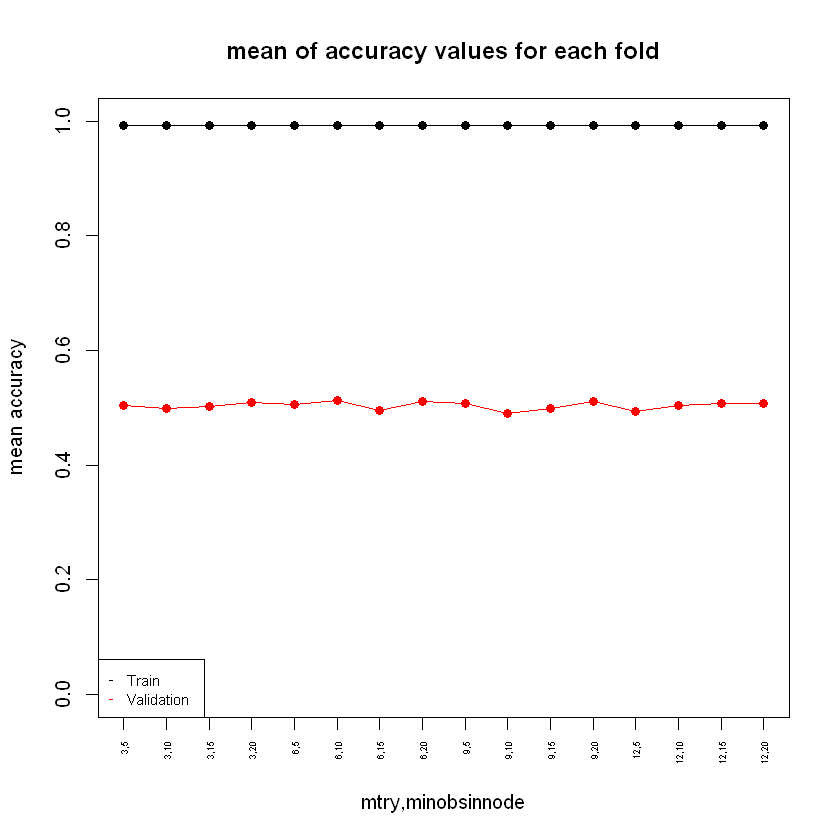

In [43]:
#We make cross-validation on our training data. We split the training data to train and validation below.
set.seed(1)
mtry=c(3,6,9,12)
minobsinnode=c(5,10,15,20)
train_val <- sample_frac(data,0.7)
mean_acc_train=c()
mean_acc_val = c()
for (a in mtry){
    for (b in minobsinnode){
        acc_train <- rep(0,10)
        acc_val <- rep(0,10)
        for (i in 1:10) {
            # These indices indicate the interval of the validation set
            indices <- (((i-1) * floor((1/10)*nrow(train_val))) + 1):((i*floor((1/10) * nrow(train_val))))

            # Exclude them from the train set
            train <- train_val[-indices,]

            # Include them in the validation set
            val <- train_val[indices,]

            # A model is learned using each training set
            rf = randomForest(result ~.,data=na.roughfix(train),na.action=na.roughfix,norm.votes = TRUE, 
                              proximity = TRUE,mtry=a,minobsinnode=b,n.trees=100,type="classification")


            # Make a prediction on the training and validation set
            pred_val=predict(rf, newdata=na.roughfix(val))
            pred_train=predict(rf, newdata=na.roughfix(train))
            

            # Assign the accuracy of this model to the ith index in accs
            #Forecast package has also accuracy, therefore Metrics:: is used
            acc_val[i] <- round(Metrics::accuracy(val$result , as.factor(pred_val)),3) 
            acc_train[i] <- round(Metrics::accuracy(train$result , as.factor(pred_train)),3)
        }

        
        mean_acc_val=c(mean_acc_val,mean(acc_val))
        mean_acc_train=c(mean_acc_train,mean(acc_train))
    }
    
    
}


indices=c()
for (a in mtry){
    for (b in minobsinnode){
        indices=c(indices,paste0(a,",",b))
    }
}

plot(mean_acc_train,type="o",pch=16,col="black",ylim=c(0,1),xaxt="n",xlab="mtry,minobsinnode"
     ,ylab="mean accuracy",main="mean of accuracy values for each fold")
points(mean_acc_val,type="o",pch=16,col="red")
axis(side=1,at=seq_along(indices),labels=indices,cex.axis=0.45,las=2)
legend(x = "bottomleft" , legend = c("Train","Validation"),col=c("black","red"),pch="-",cex=0.75)


print("Mean of acc values of each fold for training:", quote=F)
print(round(mean_acc_train,3))
print("Mean of acc values of each fold for validation:", quote=F)
print(round(mean_acc_val,3))

[1] Mean of rps values of each fold for training:
 [1] 0.032 0.032 0.032 0.032 0.031 0.031 0.031 0.031 0.031 0.031 0.031 0.031
[13] 0.031 0.031 0.031 0.031
[1] Mean of rps values of each fold for validation:
 [1] 0.212 0.213 0.213 0.211 0.213 0.213 0.213 0.213 0.213 0.214 0.213 0.214
[13] 0.216 0.215 0.215 0.215


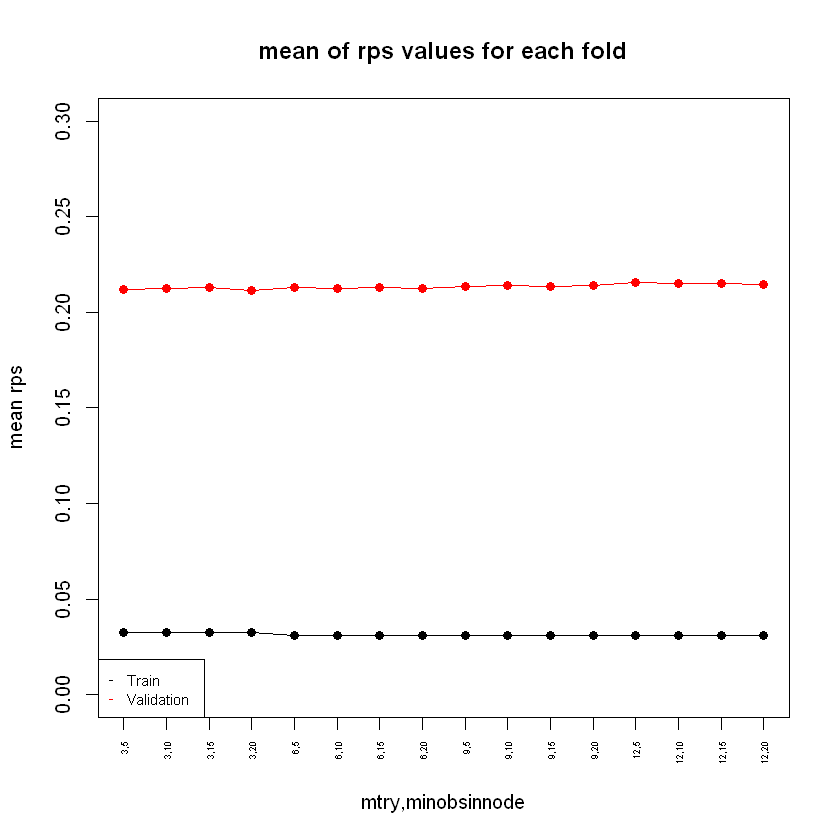

In [44]:
set.seed(1)
mtry=c(3,6,9,12)
minobsinnode=c(5,10,15,20)
train_val <- sample_frac(data,0.7)
mean_rps_train=c()
mean_rps_val = c()

for (a in mtry){
    for (b in minobsinnode){    
        rps_train <- rep(0,10)
        rps_val <- rep(0,10)
        for (i in 1:10) {
            # These indices indicate the interval of the validation set
            indices <- (((i-1) * floor((1/10)*nrow(train_val))) + 1):((i*floor((1/10) * nrow(train_val))))

            # Exclude them from the train set
            train <- train_val[-indices,]

            # Include them in the validation set
            val <- train_val[indices,]

            # A model is learned using each training set
            rf = randomForest(result ~.,data=na.roughfix(train),na.action=na.roughfix,norm.votes = TRUE, 
                              proximity = TRUE,mtry=a,minobsinnode=b,n.trees=100,type="classification")


            rps_prediction=predict(rf, newdata=na.roughfix(train),type="prob")
            rps_prediction=as.data.frame(rps_prediction)
            colnames(rps_prediction)=c("0","1","2")
            for (j in 1:nrow(rps_prediction)){
                rps_prediction[j,"result"]=train$result[j]
            }
            RPS=c()
            for (j in 1:nrow(rps_prediction)){
                if(rps_prediction[j,"result"]==0){outcomes=c(0,1,0)}
                if(rps_prediction[j,"result"]==1){outcomes=c(1,0,0)}
                if(rps_prediction[j,"result"]==2){outcomes=c(0,0,1)}
                probs=c(rps_prediction[j,"1"],rps_prediction[j,"0"],rps_prediction[j,"2"])
                RPS=c(RPS,RPS_single(probs,outcomes))
            }
            
            rps_train[i] = mean(RPS)

            rps_prediction=predict(rf, newdata=na.roughfix(val),type="prob")
            rps_prediction=as.data.frame(rps_prediction)
            colnames(rps_prediction)=c("0","1","2")
            for (j in 1:nrow(rps_prediction)){
                rps_prediction[j,"result"]=val$result[j]
            }
            RPS=c()
            for (j in 1:nrow(rps_prediction)){
                if(rps_prediction[j,"result"]==0){outcomes=c(0,1,0)}
                if(rps_prediction[j,"result"]==1){outcomes=c(1,0,0)}
                if(rps_prediction[j,"result"]==2){outcomes=c(0,0,1)}
                probs=c(rps_prediction[j,"1"],rps_prediction[j,"0"],rps_prediction[j,"2"])
                RPS=c(RPS,RPS_single(probs,outcomes))
            }
            
            rps_val[i] = mean(RPS)
        }


       
        mean_rps_val=c(mean_rps_val,mean(rps_val))
        mean_rps_train=c(mean_rps_train,mean(rps_train))

    }

}


indices=c()
for (a in mtry){
    for (b in minobsinnode){
        indices=c(indices,paste0(a,",",b))
    }
}


plot(mean_rps_train,type="o",pch=16,col="black",ylim=c(0,0.3),xaxt="n",xlab="mtry,minobsinnode"
     ,ylab="mean rps",main="mean of rps values for each fold")
points(mean_rps_val,type="o",pch=16,col="red")
axis(side=1,at=seq_along(indices),labels=indices,cex.axis=0.45,las=2)
legend(x = "bottomleft" , legend = c("Train","Validation"),col=c("black","red"),pch="-",cex=0.75)


print("Mean of rps values of each fold for training:", quote=F)
print(round(mean_rps_train,3))
print("Mean of rps values of each fold for validation:", quote=F)
print(round(mean_rps_val,3))


It seems that cross validation will not contribute us a lot. Let's choose mtry as 3 and minobsinnode as 10 and train our random forest. Then, we look at the RPS and accuracy values.

## Random Forest after Cross Validation

In [45]:
set.seed(1)
train_dt <- sample_frac(data, 0.70,)
sample_id <- as.numeric(rownames(train_dt)) # rownames() returns character so as.numeric
test_dt <- data[-sample_id,]

rf = randomForest(result ~.,data=na.roughfix(train_dt),na.action=na.roughfix,norm.votes = TRUE, proximity = TRUE,
                  ntree=100,mtry=3,minobsinnode=10,type="classification")


In [46]:
#RPS calculation
set.seed(1)
train_dt_drop_na =train_dt %>% drop_na(prob1)
test_dt_drop_na =test_dt %>% drop_na(prob1)


RPS_RFE = matrix(ncol=1, nrow=4)
rownames(RPS_RFE) = c("Bookmaker train","Bookmaker test","Model train","Model test")
colnames(RPS_RFE) = c("Random_Forest_Extended")


RPS=c()
for (i in 1:nrow(train_dt_drop_na)){
    if(train_dt_drop_na[i,"result"]==0){outcomes=c(0,1,0)}
    if(train_dt_drop_na[i,"result"]==1){outcomes=c(1,0,0)}
    if(train_dt_drop_na[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(train_dt_drop_na[i,"prob1"],train_dt_drop_na[i,"probx"],train_dt_drop_na[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
print(paste0("Bookmaker train RPS: ",mean(RPS)))


RPS=c()
for (i in 1:nrow(test_dt_drop_na)){
    if(test_dt_drop_na[i,"result"]==0){outcomes=c(0,1,0)}
    if(test_dt_drop_na[i,"result"]==1){outcomes=c(1,0,0)}
    if(test_dt_drop_na[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(test_dt_drop_na[i,"prob1"],test_dt_drop_na[i,"probx"],test_dt_drop_na[i,"prob2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
print(paste0("Bookmaker test RPS: ",mean(RPS)))


rps_prediction=predict(rf, newdata=na.roughfix(train_dt),type="prob")
rps_prediction=as.data.frame(rps_prediction)
colnames(rps_prediction)=c("0","1","2")
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=train_dt$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
print(paste0("Model train RPS: ",mean(RPS)))

rps_prediction=predict(rf, newdata=na.roughfix(test_dt),type="prob")
rps_prediction=as.data.frame(rps_prediction)
colnames(rps_prediction)=c("0","1","2")
for (i in 1:nrow(rps_prediction)){
    rps_prediction[i,"result"]=test_dt$result[i]
}
RPS=c()
for (i in 1:nrow(rps_prediction)){
    if(rps_prediction[i,"result"]==0){outcomes=c(0,1,0)}
    if(rps_prediction[i,"result"]==1){outcomes=c(1,0,0)}
    if(rps_prediction[i,"result"]==2){outcomes=c(0,0,1)}
    probs=c(rps_prediction[i,"1"],rps_prediction[i,"0"],rps_prediction[i,"2"])
    RPS=c(RPS,RPS_single(probs,outcomes))
}
print(paste0("Model test RPS: ",mean(RPS)))


[1] "Bookmaker train RPS: 0.199864573379681"
[1] "Bookmaker test RPS: 0.196700878816831"
[1] "Model train RPS: 0.0329837186897881"
[1] "Model test RPS: 0.0776378923766816"


In [47]:
#Accuracy calculation
set.seed(1)
predicted=predict(rf, newdata=train_dt)
train_dt = data.frame(train_dt, predicted)
train_dt_drop_na["prediction_bookmakers"]=ifelse((train_dt_drop_na$prob1>=train_dt_drop_na$probx & 
                                                  train_dt_drop_na$prob1>=train_dt_drop_na$prob2),1,
                                                 ifelse((train_dt_drop_na$probx>=train_dt_drop_na$prob1 & 
                                                         train_dt_drop_na$probx>=train_dt_drop_na$prob2),0,2))
x=train_dt_drop_na$result==train_dt_drop_na$prediction_bookmakers
y=train_dt$result==train_dt$predicted

print(paste0("Bookmaker train accuracy: ", length(x[x==TRUE])/nrow(train_dt_drop_na)))
print(paste0("Model train accuracy: ", length(y[y==TRUE])/nrow(train_dt)))

predicted=predict(rf, newdata=test_dt)
test_dt = data.frame(test_dt, predicted)
test_dt_drop_na["prediction_bookmakers"]=ifelse((test_dt_drop_na$prob1>=test_dt_drop_na$probx & 
                                                 test_dt_drop_na$prob1>=test_dt_drop_na$prob2),1,
                                                ifelse((test_dt_drop_na$probx>=test_dt_drop_na$prob1 & 
                                                        test_dt_drop_na$probx>=test_dt_drop_na$prob2),0,2))
x=test_dt_drop_na$result==test_dt_drop_na$prediction_bookmakers
y=test_dt$result==test_dt$predicted


print(paste0("Bookmaker test accuracy: ", length(x[x==TRUE])/nrow(test_dt_drop_na)))
print(paste0("Model test accuracy: ", length(y[y==TRUE])/nrow(test_dt)))



[1] "Bookmaker train accuracy: 0.51310861423221"
[1] "Model train accuracy: 1"
[1] "Bookmaker test accuracy: 0.547738693467337"
[1] "Model test accuracy: 0.887892376681614"


After cross validation we see very small changes on model train RPS and model test RPS values. We have very small changes and there is no need to make prediction again after training with these parameters. We can intuitively think that the new predictions will not be very different. We also see that our model before cross validation is a good model.